##Прогнозирование отклика на маркетинговую кампанию

**Задача** - Классификация



**Цель** - Предсказать, откликнется ли покупатель на маркетинговую кампанию


**Таргет** - Response




##Подключение библиотек, загрузка данных, первичный анализ

# Подключение библиотек, загрузка данных, первичный анализ

In [160]:
import mlflow
import os
from getpass import getpass

os.environ['MLFLOW_TRACKING_USERNAME'] = 'daryafralova'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '10deb4cbb5ca39ebabdd04f72fdd08350a6b44d2'
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = 'MLFlow'

mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

In [161]:
import sys
print(sys.version)

3.10.12 (main, Feb  4 2025, 14:57:36) [GCC 11.4.0]


In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import gdown
import seaborn as sns
from scipy.stats import probplot
import numpy as np
from scipy.stats import shapiro
from scipy.stats import norm
from scipy.stats import mannwhitneyu
pd.options.display.float_format = lambda x: ('%.12f' % x).rstrip('0').rstrip('.')
from pycaret.classification import *
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import scipy.stats as stats
from scipy.stats import ttest_ind
import mlflow
import os
from getpass import getpass

In [163]:
gdown.download('https://drive.google.com/uc?id=17puPY2cKoC0UEmrAyWhiVqLMbrrKNjFV')

Downloading...
From: https://drive.google.com/uc?id=17puPY2cKoC0UEmrAyWhiVqLMbrrKNjFV
To: /home/alorozhkov/jup/marketing_campaign.csv
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220k/220k [00:00<00:00, 3.10MB/s]


'marketing_campaign.csv'

In [164]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [165]:
df.head(1)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1


In [166]:
df.shape

(2240, 29)

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [168]:
print(df.columns.tolist())

['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


In [169]:
df.iloc[:, 10:20].head()

,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,88,546,172,88,88,3,8,10,4,7
1,1,6,2,1,6,2,1,1,2,5
2,49,127,111,21,42,1,8,2,10,4
3,4,20,10,3,5,2,2,0,4,6
4,43,118,46,27,15,5,5,3,6,5


# Описание данных

Описание данных:

ID: уникальный id клиента

Year_Birth: дата рождения

Education: какое образование

Marital_Status: семейное положение

Income: годовой доход семьи клиента

Kidhome: кол-во детей

Teenhome: кол-во подростков

Dt_Customer: дата регистрации клиента

Recency: кол-во дней с последней покупки

MntWines: сумма, потраченная на вино за последние 2 года

MntFruits: сумма, потраченная на фрукты за последние 2 года

MntMeatProducts: сумма, потраченная на мясо за последние 2 года

MntFishProducts: сумма, потраченная на рыбу за последние 2 года

MntSweetProducts: сумма, потраченная на сладости за последние 2 года

MntGoldProds: сумма, потраченная на премиум товары за последние 2 года

NumDealsPurchases: количество покупок, совершенных со скидкой

NumWebPurchases:  количество покупок, совершенных онлайн

NumCatalogPurchases:  количество покупок, совершенных с использованием каталога

NumStorePurchases: количество покупок, совершенных непосредственно в магазинах

NumWebVisitsMonth: количество посещений веб-сайта компании за последний месяц

AcceptedCmp3: 1, если клиент принял предложение в 3-й кампании, в противном случае 0

AcceptedCmp4: 1, если клиент принял предложение в 4-й кампании, в противном случае 0

AcceptedCmp5: 1, если клиент принял предложение в 5-й кампании, в противном случае 0

AcceptedCmp1: 1, если клиент принял предложение в рамках 1-й кампании, в противном случае 0

AcceptedCmp2: 1, если клиент принял предложение во время 2-й кампании, в противном случае 0

Complain: 1, если клиент жаловался в течение последних 2 лет, 0 в противном случае

Z_CostContact: удаляю, т.к. данные име.т одинаковые значения во всем датасете
Z_Revenue: удаляю, т.к. данные име.т одинаковые значения во всем датасете

Response: 1, если клиент принял предложение в рамках последней кампании, 0 в противном случае

# Предобработка данных

In [170]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [171]:
#Вывожу столбцы у кого тоже Income == NaN
df[df['Income'].isna()][['ID', 'Education', 'Marital_Status', 'Year_Birth']]

,ID,Education,Marital_Status,Year_Birth
10,1994,Graduation,Married,1983
27,5255,Graduation,Single,1986
43,7281,PhD,Single,1959
48,7244,Graduation,Single,1951
58,8557,Graduation,Single,1982
71,10629,2n Cycle,Married,1973
90,8996,PhD,Married,1957
91,9235,Graduation,Single,1957
92,5798,Master,Together,1973
128,8268,PhD,Married,1961


In [172]:
#Группирую по Education и заполняю NaN медианным значением по Education
data = df.copy()
data['Income'] = data.groupby('Education')['Income'].transform(
    lambda x: x.fillna(x.median())
)

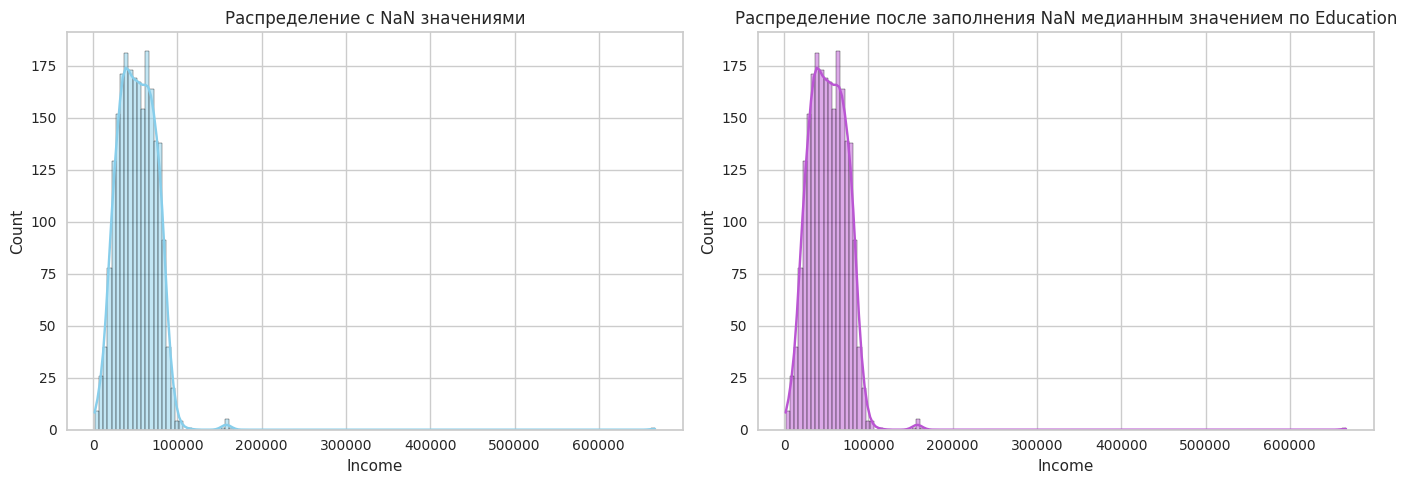

In [173]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data['Income'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Распределение с NaN значениями')
axes[0].set_xlabel('Income')

sns.histplot(data['Income'], kde=True, ax=axes[1], color='mediumorchid')
axes[1].set_title('Распределение после заполнения NaN медианным значением по Education')
axes[1].set_xlabel('Income')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.tight_layout()
plt.show()

In [174]:
data.duplicated().sum()

0

In [175]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240,5592.159821428571,3246.662197564341,0,2828.25,5458.5,8427.75,11191
Year_Birth,2240,1968.805803571429,11.984069456886,1893,1959,1970,1977,1996
Income,2240,52242.594866071428,25039.061737557713,1730,35538.75,51498.5,68289.75,666666
Kidhome,2240,0.444196428571,0.538398097735,0,0,0,1,2
Teenhome,2240,0.50625,0.54453823077,0,0,0,1,2
Recency,2240,49.109375,28.962452808378,0,24,49,74,99
MntWines,2240,303.935714285714,336.597392605372,0,23.75,173.5,504.25,1493
MntFruits,2240,26.302232142857,39.773433764579,0,1,8,33,199
MntMeatProducts,2240,166.95,225.715372511754,0,16,67,232,1725
MntFishProducts,2240,37.525446428571,54.628979402878,0,3,12,50,259


**Вывод:**
*   **Year_Birth**  - Нужно превратить в возраст и проверить на выбросы (люди 120+ лет — подозрительно)
*   **Kidhome / Teenhome** - Бинарные значения, максимум 2 — объединю  их в фичу HasChildren
*   **AcceptedCmp5/3/1/2/4** - Объединяю в фичу TotalAcceptedCmp
*   **NumCatalogPurchases/NumWebPurchases/NumStorePurchases** - объединяю в одну фичу AvgPurchaseActivity
*   **MaritalStatus** - В новую фичу MaritalStatus_2 со значениями 0 - Not Partnered или 1=Maried
*   **Education** - Преобразовать к категориальному признаку
*   **MntWines/MntFruits/MntMeatProducts/MntFishProducts/MntSweetProducts/MntGoldProds** - В новую фичу TotalSpent


### Фича Age

In [176]:
data['Age'] = 2025 - data['Year_Birth']

In [177]:
data[data['Age'] > 100]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age
192,7829,1900,2n Cycle,Divorced,36640,1,0,26-09-2013,99,15,...,0,0,0,0,0,1,3,11,0,125
239,11004,1893,2n Cycle,Single,60182,0,1,17-05-2014,23,8,...,0,0,0,0,0,0,3,11,0,132
339,1150,1899,PhD,Together,83532,0,0,26-09-2013,36,755,...,0,0,1,0,0,0,3,11,0,126


In [178]:
data = data[(data['Age'] <= 100)]

In [179]:
data['Age'].max()

85

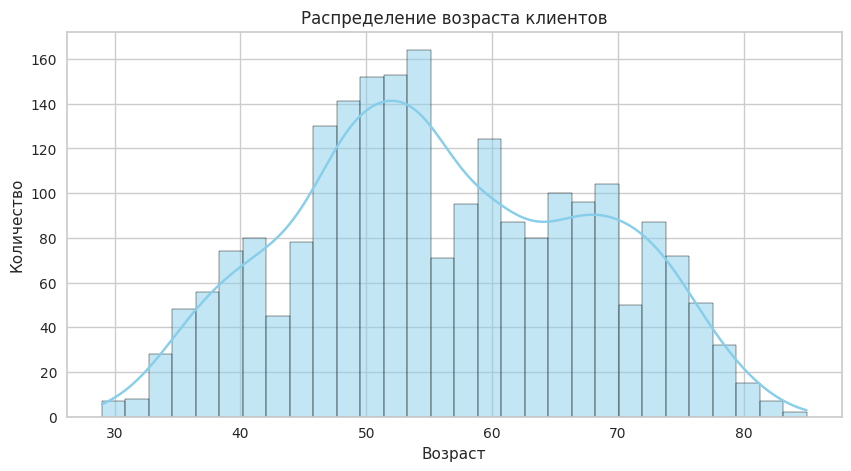

In [180]:
plt.figure(figsize=(10, 5))
sns.histplot(data['Age'], bins=30, kde=True, color='skyblue')
plt.title('Распределение возраста клиентов')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

### Фича HasChildren

In [181]:
data.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age
0,5524,1957,Graduation,Single,58138,0,0,04-09-2012,58,635,...,0,0,0,0,0,0,3,11,1,68
1,2174,1954,Graduation,Single,46344,1,1,08-03-2014,38,11,...,0,0,0,0,0,0,3,11,0,71
2,4141,1965,Graduation,Together,71613,0,0,21-08-2013,26,426,...,0,0,0,0,0,0,3,11,0,60


In [182]:
data['TotalChildren'] = data['Kidhome'] + data['Teenhome']

In [183]:
data[['Kidhome', 'Teenhome', 'TotalChildren']].head()

,Kidhome,Teenhome,TotalChildren
0,0,0,0
1,1,1,2
2,0,0,0
3,1,0,1
4,1,0,1


In [184]:
# Создаю фичу HasChildren
data['HasChildren'] = (data['TotalChildren'] > 0).astype(int)

### Фича Marital_Status

In [185]:
data['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [186]:
# Добавление фичи MaritalFlag 
data['MaritalFlag'] = data['Marital_Status'].isin(['Married', 'Together']).astype(int)

### Фича TotalSpent

In [187]:
mnt_cols = [
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds'
]
data['TotalSpent'] = data[mnt_cols].sum(axis=1)

In [188]:
data.groupby('Response')['TotalSpent'].describe()

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,1903,538.759327377824,552.48492648357,5,62,315,955,2525
1,334,987.392215568862,719.009695206596,17,252,1057.5,1617,2525


**Люди с (Response = 1), тратят значительно больше**



### Фича Customer_Since_Years  

In [189]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], dayfirst=True)
data['Customer_Since_Days'] = (pd.Timestamp.today() - data['Dt_Customer']).dt.days

In [190]:
data['Customer_Since_Years'] = (data['Customer_Since_Days'] / 365.25).astype(int)

In [191]:
data.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Z_CostContact,Z_Revenue,Response,Age,TotalChildren,HasChildren,MaritalFlag,TotalSpent,Customer_Since_Days,Customer_Since_Years
0,5524,1957,Graduation,Single,58138,0,0,2012-09-04,58,635,...,3,11,1,68,0,0,0,1617,4639,12
1,2174,1954,Graduation,Single,46344,1,1,2014-03-08,38,11,...,3,11,0,71,2,1,0,27,4089,11
2,4141,1965,Graduation,Together,71613,0,0,2013-08-21,26,426,...,3,11,0,60,0,0,1,776,4288,11


### Фича TotalPurchaseActivity

In [192]:
# Создаю Фичу вовлеченности покупателя
data['TotalPurchaseActivity'] = data[['NumCatalogPurchases', 'NumWebPurchases', 'NumStorePurchases']].sum(axis=1)

In [193]:
data.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Z_Revenue,Response,Age,TotalChildren,HasChildren,MaritalFlag,TotalSpent,Customer_Since_Days,Customer_Since_Years,TotalPurchaseActivity
0,5524,1957,Graduation,Single,58138,0,0,2012-09-04,58,635,...,11,1,68,0,0,0,1617,4639,12,22
1,2174,1954,Graduation,Single,46344,1,1,2014-03-08,38,11,...,11,0,71,2,1,0,27,4089,11,4
2,4141,1965,Graduation,Together,71613,0,0,2013-08-21,26,426,...,11,0,60,0,0,1,776,4288,11,20


### Фича участия в предыдущих кампаниях TotalAcceptedCmp

In [194]:
data['TotalAcceptedCmp'] = data[['AcceptedCmp1', 'AcceptedCmp3', 'AcceptedCmp5', 'AcceptedCmp2', 'AcceptedCmp4']].sum(axis=1)

### Создание фичи HigherEducatuin (Преобразование Education к бинарному типу данных)

In [195]:
data['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [196]:
higher_edu = ['Graduation', 'Master', 'PhD']
data['HigherEducation'] = data['Education'].isin(higher_edu).astype(int)

### Удаление ненужных столбцов

In [197]:
data.drop(['NumCatalogPurchases', 'NumWebPurchases', 'NumStorePurchases', 'NumDealsPurchases'], axis=1, inplace=True) 

In [198]:
data.drop(['AcceptedCmp1', 'AcceptedCmp3', 'AcceptedCmp5', 'AcceptedCmp2', 'AcceptedCmp4'], axis=1, inplace=True) 

In [199]:
data.drop(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'], axis=1, inplace=True) 

In [200]:
data.drop(['Marital_Status', 'Education', 'Kidhome', 'Teenhome', 'TotalChildren', 'Year_Birth', 'Z_CostContact', 'Z_Revenue', 'Dt_Customer', 'Customer_Since_Days'], axis=1, inplace=True)

In [201]:
data.head(5)

,ID,Income,Recency,NumWebVisitsMonth,Complain,Response,Age,HasChildren,MaritalFlag,TotalSpent,Customer_Since_Years,TotalPurchaseActivity,TotalAcceptedCmp,HigherEducation
0,5524,58138,58,7,0,1,68,0,0,1617,12,22,0,1
1,2174,46344,38,5,0,0,71,1,0,27,11,4,0,1
2,4141,71613,26,4,0,0,60,0,1,776,11,20,0,1
3,6182,26646,26,6,0,0,41,1,1,53,11,6,0,1
4,5324,58293,94,5,0,0,44,1,1,422,11,14,0,1


In [202]:
## Feature eng_1

In [203]:
#Смотрю feture eng на полученныхз признаках
features_1 = ['ID', 'Income', 'Recency', 'NumWebVisitsMonth', 'Complain', 'Age', 'HasChildren', 'MaritalFlag', 'TotalSpent', 
            'Customer_Since_Years', 
            'TotalPurchaseActivity',
            'TotalAcceptedCmp', 'HigherEducation']
        
X = data[features_1]
y = data['Response']


In [204]:
def fit_catboost_model(X, y, features=None):
    X_filtered = X[features] if features else X

    # Расчет весов классов (пример с бинарной классификацией)
    class_counts = y.value_counts()
    total = len(y)
    class_weights = [total / class_counts[cls] for cls in sorted(class_counts.index)]

    model = CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.1,
        verbose=False,
        class_weights=class_weights
    )

    model.fit(X_filtered, y)

    feature_importance = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': X_filtered.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    y_pred = model.predict(X_filtered)

    display(feature_importance_df)

    return model

In [205]:
from catboost import CatBoostClassifier

In [206]:
_ = fit_catboost_model(X, y)

,Feature,Importance
2,Recency,17.081695325015
1,Income,12.545365125507
8,TotalSpent,11.388274338092
0,ID,10.349810307995
5,Age,9.924043117223
11,TotalAcceptedCmp,9.025349456156
3,NumWebVisitsMonth,7.748648490103
9,Customer_Since_Years,6.400197297268
10,TotalPurchaseActivity,5.470325300573
7,MaritalFlag,5.254006720551


In [207]:
from tqdm import tqdm

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.03it/s]


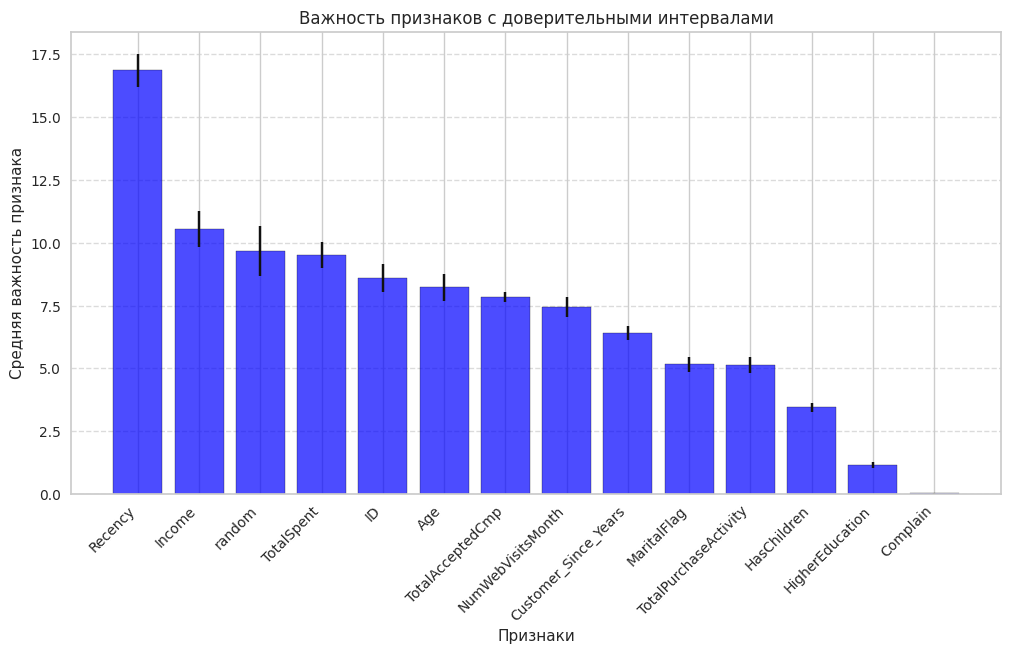

In [208]:
n_iterations = 10
features = list(X.columns) + ['random']

# Словарь для хранения значений важности признаков
feature_importance_records = {feature: [] for feature in features}

# Запускаем обучение много раз
for _ in tqdm(range(n_iterations)):
    X['random'] = np.random.random(size=len(X))
    model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
    model.fit(X, y)

    # Получаем важность признаков
    feature_importance = model.feature_importances_

    # Записываем значения в словарь
    for feature, importance in zip(X.columns, feature_importance):
        feature_importance_records[feature].append(importance)

# Создаём DataFrame с итоговыми средними и стандартными отклонениями
feature_importance_stats = pd.DataFrame({
    'feature': list(feature_importance_records.keys()),
    'mean': [np.mean(values) for values in feature_importance_records.values()],
    'std': [np.std(values) for values in feature_importance_records.values()]
}).sort_values(by='mean', ascending=False)

# display(feature_importance_stats)

plt.figure(figsize=(12, 6))
plt.bar(
    feature_importance_stats['feature'], 
    feature_importance_stats['mean'], 
    yerr=feature_importance_stats['std'], 
    capsize=5, 
    color='blue', 
    edgecolor='black', 
    alpha=0.7
)

plt.xlabel('Признаки')
plt.ylabel('Средняя важность признака')
plt.title('Важность признаков с доверительными интервалами')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение графика
plt.show()

In [209]:
import shap 
from catboost import CatBoostClassifier

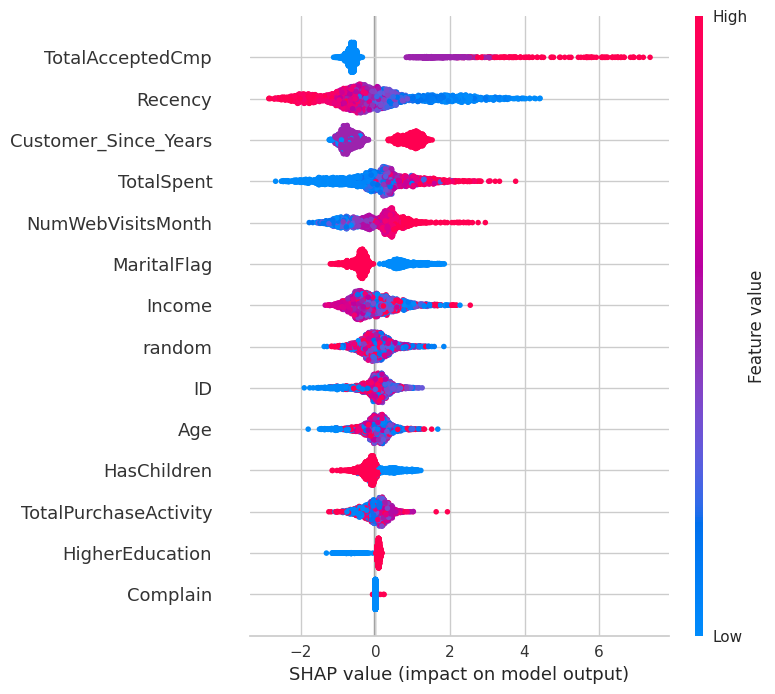

In [210]:
# Обучаем модель
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
model.fit(X, y)

# Инициализируем SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# SHAP summary plot
shap.summary_plot(shap_values, X)

In [211]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2237,5590.726419311578,3245.118591497697,0,2829,5455,8427,11191
Income,2237,52232.033303531513,25044.375877751736,1730,35523,51479,68281,666666
Recency,2237,49.104604380867,28.956073098902,0,24,49,74,99
NumWebVisitsMonth,2237,5.319177469826,2.42638552774,0,3,6,7,20
Complain,2237,0.008940545373,0.094151870551,0,0,0,0,1
Response,2237,0.149307107734,0.356470615409,0,0,0,0,1
Age,2237,56.098345999106,11.701917260311,29,48,55,66,85
HasChildren,2237,0.715243629861,0.451399231996,0,0,1,1,1
MaritalFlag,2237,0.645060348681,0.478602017608,0,0,1,1,1
TotalSpent,2237,605.743406347787,601.840466114246,5,69,396,1045,2525


Вывод по статистике:
- Income - Максимум 666666 — выглядит как явная аномалия (в 10 раз выше 75-го перцентиля = 68281)
- Complain - Очень несбалансирована. Почти все = 0
- Response - Очень несбалансирована. Буду использовать Class weights при обучении
- Age- все ок
- HasChildren, MaritalFlag, HigherEducation - Уже бинарные и сбалансированные. Можно использовать как есть
- TotalSpent- Очень широкий разброс (от 5 до 2525), и среднее почти равно стандартному отклонению.
- Customer_Since_Years-Минимум = 10, максимум = 12 → низкая дисперсия, почти не меняется.Это говорит о том, что эта фича может быть не очень информативной, если все клиенты похожи по времени, когда начали пользоваться услугами.
- TotalPurchaseActivity- Отличная фича, разумно распределена.Можно создать индикаторы активности: df['IsHighlyActive'] = (df['TotalPurchaseActivity'] > 20).astype(int)
- TotalAcceptedCmp-Среднее = 0.3, максимум = 4 — значит, большинство не приняли ни одной кампании.Можно создать бинарный флаг:df['HasAcceptedCmp'] = (df['TotalAcceptedCmp'] > 0).astype(int)

Что буду делать?
- Income- анализ и проверка на выбросы
- Сomplain - удалю
- Response - Буду использовать Class weights при обучении
- TotalSpent - логарифмирую
- Customer_Since_Years - удалю
- TotalPurchaseActivity - создам на ее основе бинарный индикатор активности
- TotalAcceptedCmp - создам бинарный флаг

In [212]:
# Логарифмирование TotalSpent
data['LogTotalSpent'] = np.log1p(data['TotalSpent'])

In [213]:
# Округление для лучшей работы с графиками
data['LogTotalSpentRounded'] = data['LogTotalSpent'].round(1)

In [214]:
# Удаление признаков
data.drop(['Complain', 'Customer_Since_Years', 'TotalSpent', 'ID'], axis=1, inplace=True) 

In [215]:
data.head(2)

,Income,Recency,NumWebVisitsMonth,Response,Age,HasChildren,MaritalFlag,TotalPurchaseActivity,TotalAcceptedCmp,HigherEducation,LogTotalSpent,LogTotalSpentRounded
0,58138,58,7,1,68,0,0,22,0,1,7.388946097618,7.4
1,46344,38,5,0,71,1,0,4,0,1,3.332204510175,3.3


## Feature eng_2 на полученных признаках

In [216]:
#Смотрю feture eng на полученныхз признаках
features_1 = ['Income', 'Recency', 'NumWebVisitsMonth', 'Age', 'HasChildren', 'MaritalFlag',  
            'TotalPurchaseActivity',
            'TotalAcceptedCmp', 'HigherEducation', 'LogTotalSpent']
        
X = data[features_1]
y = data['Response']

In [217]:
def fit_catboost_model(X, y, features=None):
    X_filtered = X[features] if features else X

    # Расчет весов классов (пример с бинарной классификацией)
    class_counts = y.value_counts()
    total = len(y)
    class_weights = [total / class_counts[cls] for cls in sorted(class_counts.index)]

    model = CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.1,
        verbose=False,
        class_weights=class_weights
    )

    model.fit(X_filtered, y)

    feature_importance = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': X_filtered.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    y_pred = model.predict(X_filtered)

    display(feature_importance_df)

    return model

In [218]:
_ = fit_catboost_model(X, y)

,Feature,Importance
1,Recency,17.402597317256
0,Income,16.571766809117
9,LogTotalSpent,15.290485996748
3,Age,12.393375685696
2,NumWebVisitsMonth,11.046109881276
7,TotalAcceptedCmp,8.864163521693
6,TotalPurchaseActivity,7.837089908865
5,MaritalFlag,5.565681490951
4,HasChildren,3.910848026596
8,HigherEducation,1.117881361801


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.15it/s]


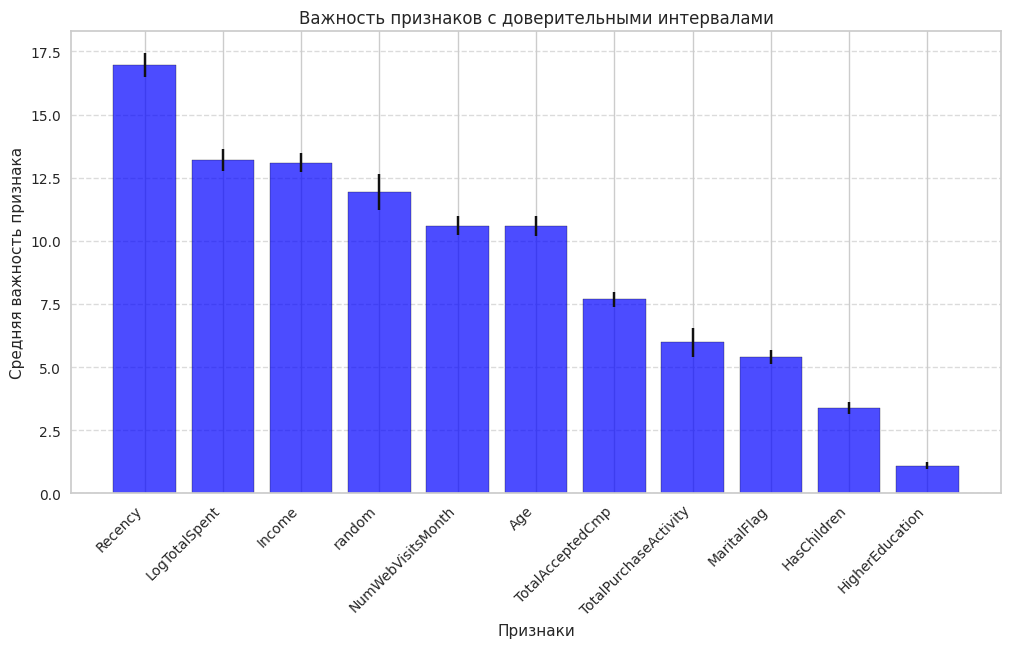

In [219]:
n_iterations = 10
features = list(X.columns) + ['random']

# Словарь для хранения значений важности признаков
feature_importance_records = {feature: [] for feature in features}

# Запускаем обучение много раз
for _ in tqdm(range(n_iterations)):
    X['random'] = np.random.random(size=len(X))
    model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
    model.fit(X, y)

    # Получаем важность признаков
    feature_importance = model.feature_importances_

    # Записываем значения в словарь
    for feature, importance in zip(X.columns, feature_importance):
        feature_importance_records[feature].append(importance)

# Создаём DataFrame с итоговыми средними и стандартными отклонениями
feature_importance_stats = pd.DataFrame({
    'feature': list(feature_importance_records.keys()),
    'mean': [np.mean(values) for values in feature_importance_records.values()],
    'std': [np.std(values) for values in feature_importance_records.values()]
}).sort_values(by='mean', ascending=False)

# display(feature_importance_stats)

plt.figure(figsize=(12, 6))
plt.bar(
    feature_importance_stats['feature'], 
    feature_importance_stats['mean'], 
    yerr=feature_importance_stats['std'], 
    capsize=5, 
    color='blue', 
    edgecolor='black', 
    alpha=0.7
)

plt.xlabel('Признаки')
plt.ylabel('Средняя важность признака')
plt.title('Важность признаков с доверительными интервалами')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение графика
plt.show()

In [220]:
cond = feature_importance_stats['feature'] == 'random'
random_mean_importance = feature_importance_stats.loc[cond, 'mean'].values[0]

cond = feature_importance_stats['mean'] > random_mean_importance
better_than_random = feature_importance_stats[cond]

features = better_than_random['feature'].to_list()

In [221]:
_ = fit_catboost_model(X, y, features)

,Feature,Importance
1,LogTotalSpent,36.985222520704
2,Income,34.608223854332
0,Recency,28.406553624964


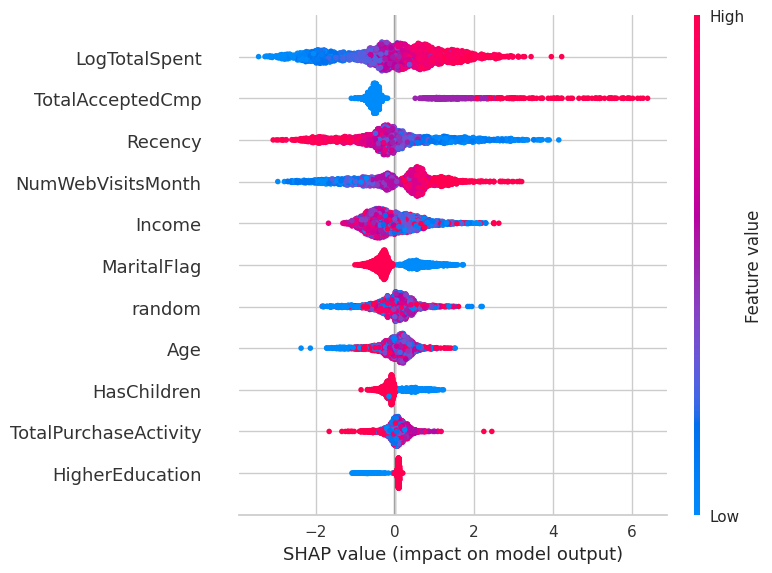

In [222]:
# Обучаем модель
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
model.fit(X, y)

# Инициализируем SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# SHAP summary plot
shap.summary_plot(shap_values, X)

Вывод по SHAP:
- LogTotalSpent - самый важный признак, высокие значения которого сильно повышают вероятность отклика.
- TotalAcceptedCmp - сильное положительное влияние при высоких значениях --> люди участвовавшие в прошлых кампаниях чаще откликаются
- Recency - низкие значения повышают отклик. Т.е. чем меньше времени прошло с последнего отклика, тем выше шанс нового отклика.
- NumWebVisitsMonth - при большом числе визитов отклик более вероятен
- MaritalFlag - люди, не состоявшие в браке имеют большую тенеденцию к откликам
- Income -  высокий разброз значений,  влияние не абсолютно стабильное
- Age - Молодые пользователи чаще откликаются, пожилые — реже. Однако эффект не резкий — SHAP значения умеренные, значит, влияние Age существенно, но не решающе.
- random -  почти симметричен вокруг 0
- HasChildren - семьи без детей  имеют большую тенеденцию к откликам
- TotalPurchaseActivity - Большинство точек имеют значения около нуля. Это говорит о низком  вкладе признака в предсказания модели — TotalPurchaseActivity почти не влияет на решение модели в большинстве случаев.
- HigherEducation - неинформативен для модели 
  


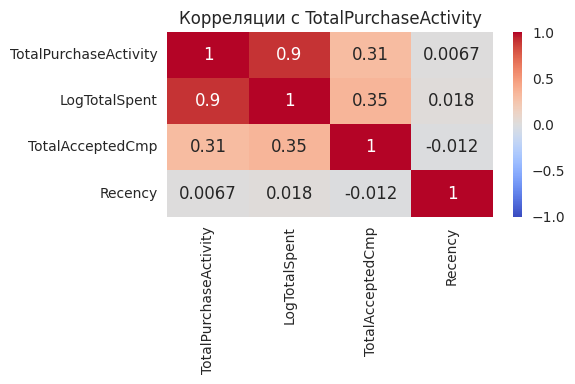

In [223]:
# Список признаков для анализа
features_to_check = ['TotalPurchaseActivity', 'LogTotalSpent', 'TotalAcceptedCmp', 'Recency']

# Вычисляем корреляционную матрицу
corr_matrix = data[features_to_check].corr()

# Визуализируем
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляции с TotalPurchaseActivity')
plt.tight_layout()
plt.show()

Между TotalPurchaseActivity  и LogTotalSpent  есть линейная зависимость. TotalPurchaseActivity в модели ведёт себя как вторичный признак, потому что основной вклад даёт LogTotalSpent, с которым она на 90% скоррелирована. Это объясняет, почему SHAP-график показывает низкую важность TotalPurchaseActivity: модель уже "учитывает" эту информацию через LogTotalSpent. Данное явление называется мультиколлинеарностью                           

# EDA

## Response

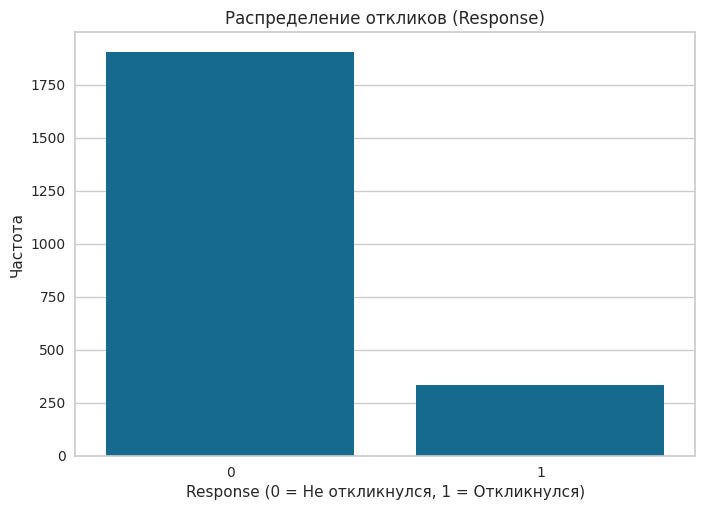

In [224]:
# Строим гистограмму для переменной Response
sns.countplot(x='Response', data=data)

# Настроим заголовок и подписи
plt.title('Распределение откликов (Response)')
plt.xlabel('Response (0 = Не откликнулся, 1 = Откликнулся)')
plt.ylabel('Частота')

# Отображаем график
plt.show()

In [225]:
data.head(2)

,Income,Recency,NumWebVisitsMonth,Response,Age,HasChildren,MaritalFlag,TotalPurchaseActivity,TotalAcceptedCmp,HigherEducation,LogTotalSpent,LogTotalSpentRounded
0,58138,58,7,1,68,0,0,22,0,1,7.388946097618,7.4
1,46344,38,5,0,71,1,0,4,0,1,3.332204510175,3.3


## HasChildren

In [226]:
# Доля откликнувшихся(Response=1) по фиче HasChildren
response_by_children = data.groupby('HasChildren')['Response'].mean().reset_index()
print(response_by_children)

   HasChildren       Response
0            0 0.265306122449
1            1       0.103125


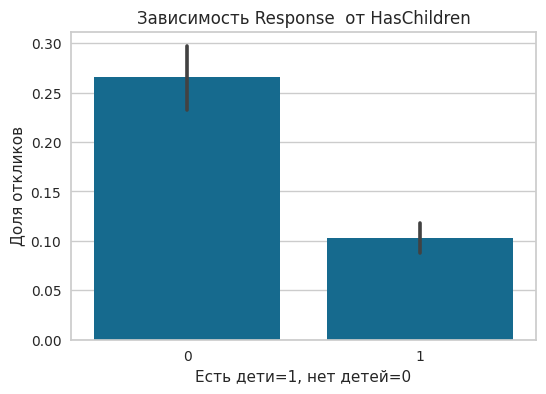

In [227]:
plt.figure(figsize=(6,4))
sns.barplot(x='HasChildren', y='Response', data=data)
plt.title('Зависимость Response  от HasChildren')
#plt.rcParams['font.family'] = 'DejaVu Sans'
plt.xlabel('Есть дети=1, нет детей=0')
plt.ylabel('Доля откликов')
plt.show()

HasChildren(0) - откликунулось 26.5%
HasChildren(1) - откликнулось 10.3%
Люди без детей откликаются на предложения значительно чаще, чем те, у кого есть дети.

## Recency 

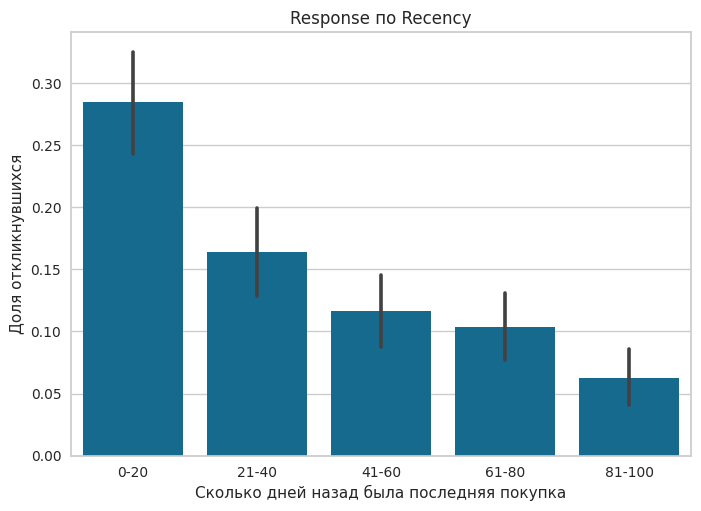

In [228]:
# Recency
data['RecencyGroup'] = pd.cut(data['Recency'], bins=[-1, 20, 40, 60, 80, 100], labels=['0-20','21-40','41-60','61-80','81-100'])
sns.barplot(data=data, x='RecencyGroup', y='Response')
plt.title('Response по Recency')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.xlabel('Сколько дней назад была последняя покупка')
plt.ylabel('Доля откликнувшихся')
plt.show()

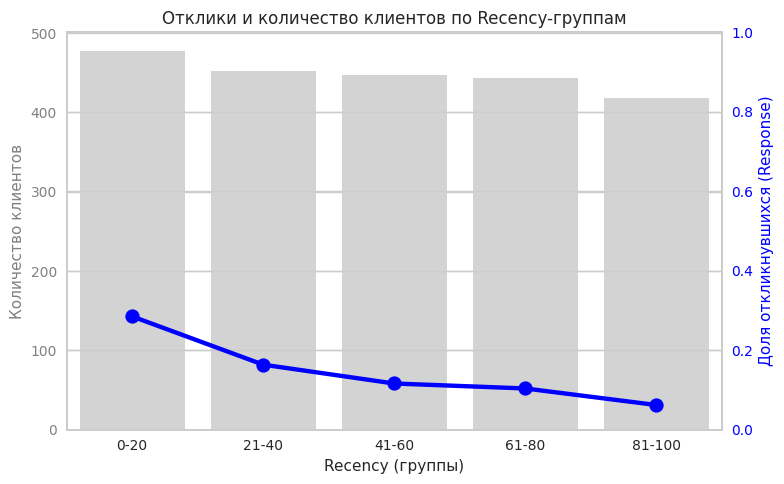

In [229]:
# Подсчёт доли откликов по группам Recency
response_rate = data.groupby('RecencyGroup')['Response'].mean()
counts = data['RecencyGroup'].value_counts().sort_index()

# Создание графика с двумя осями
fig, ax1 = plt.subplots(figsize=(8, 5))

# Левая ось Y — количество клиентов (гистограмма)
sns.barplot(x=counts.index, y=counts.values, ax=ax1, color='lightgray')
ax1.set_ylabel('Количество клиентов', color='gray')
ax1.set_xlabel('Recency (группы)')
ax1.tick_params(axis='y', labelcolor='gray')

# Правая ось Y — доля откликов (линейный график)
ax2 = ax1.twinx()
sns.pointplot(x=response_rate.index, y=response_rate.values, ax=ax2, color='blue', markers='o', linestyles='-')
ax2.set_ylabel('Доля откликнувшихся (Response)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 1)

# Заголовок
plt.title('Отклики и количество клиентов по Recency-группам')
plt.tight_layout()
plt.show()

Анализ показал, что количество клиентов в каждой группе Recency примерно одинаковое, что исключает влияние дисбаланса данных на результат. При этом чётко прослеживается закономерность - чем дольше клиент не совершал покупку, тем ниже вероятность его отклика на маркетинговые кампании. Это говорит о том, что свежая покупательская активность — ключевой фактор вовлечённости. Наиболее откликаются клиенты, совершившие покупку в последние 20 дней.

In [230]:
# data.drop(['RecencyGroup'], axis=1, inplace=True)

## MaritalFlag

In [231]:
# Вычислим корреляцию
correlation_m_r = data['MaritalFlag'].corr(data['Response'])

print(f'Корреляция между MaritalFlag и Response: {correlation_m_r}')

Корреляция между MaritalFlag и Response: -0.15059867663155668


In [232]:
# Группируем по MaritalFlag и считаем среднее значение Response
response_by_marital = data.groupby('MaritalFlag')['Response'].mean().reset_index()

print(response_by_marital)

   MaritalFlag       Response
0            0 0.221662468514
1            1 0.109494109494


In [233]:
marital_distribution = data['MaritalFlag'].value_counts(normalize=True).reset_index()
marital_distribution.columns = ['MaritalFlag', 'Proportion']

print(marital_distribution)

   MaritalFlag     Proportion
0            1 0.645060348681
1            0 0.354939651319


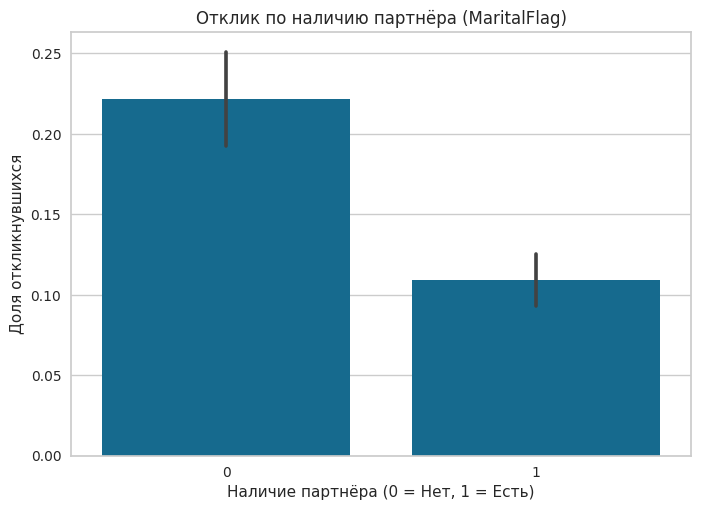

In [234]:
#График откликов по MaritalFlag
sns.barplot(x='MaritalFlag', y='Response', data=data)

plt.title('Отклик по наличию партнёра (MaritalFlag)')
plt.xlabel('Наличие партнёра (0 = Нет, 1 = Есть)')
plt.ylabel('Доля откликнувшихся')

plt.show()

## Income

In [235]:
# Корреляцию между доходом и откликами
correlation_i_r = data['Income'].corr(data['Response'])
print(f'Корреляция между Income и Response: {correlation_i_r}')

Корреляция между Income и Response: 0.13301550448512658


In [236]:
# Ищу выбросы
Q1 = data['Income'].quantile(0.25)
Q3 = data['Income'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Income'] < lower_bound) | (data['Income'] > upper_bound)]
print(f"Количество выбросов: {len(outliers)}")

Количество выбросов: 8


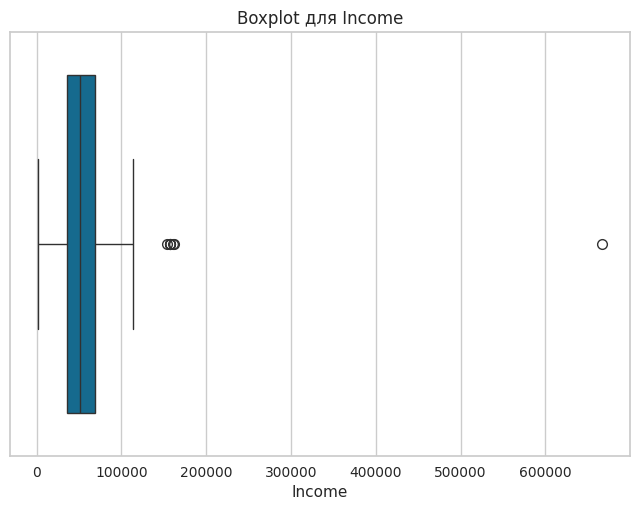

In [237]:
sns.boxplot(x=data['Income'])
plt.title('Boxplot для Income')
plt.show()

In [238]:
print(data['Income'].describe())

count                 2237
mean    52232.033303531513
std     25044.375877751736
min                   1730
25%                  35523
50%                  51479
75%                  68281
max                 666666
Name: Income, dtype: float64


In [239]:
# Удаляю выбросы
data = data[(data['Income'] >= lower_bound) & (data['Income'] <= upper_bound)]

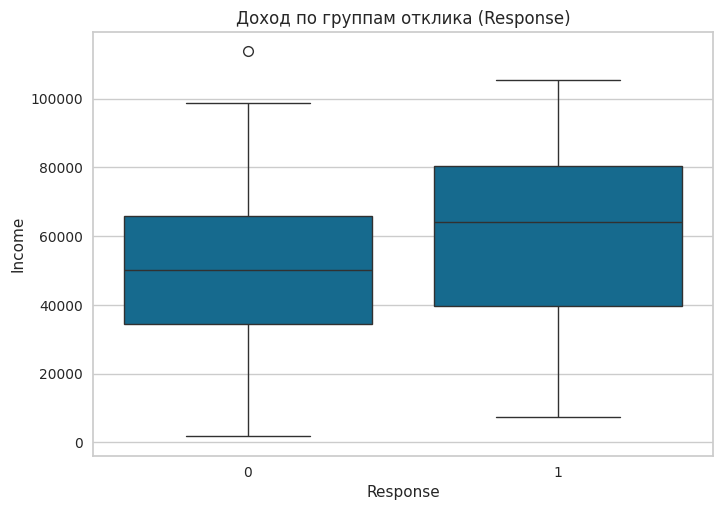

In [240]:
sns.boxplot(x='Response', y='Income', data=data)
plt.title('Доход по группам отклика (Response)')
plt.show()

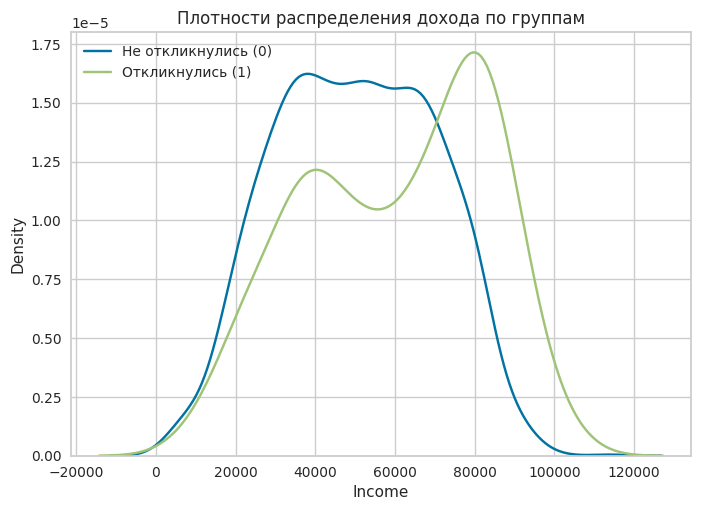

In [241]:
sns.kdeplot(data[data['Response'] == 0]['Income'], label='Не откликнулись (0)')
sns.kdeplot(data[data['Response'] == 1]['Income'], label='Откликнулись (1)')
plt.title('Плотности распределения дохода по группам')
plt.legend()
plt.show()

In [242]:
# Разбиваю доход на группы
data['IncomeGroup'] = pd.qcut(data['Income'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])
pd.crosstab(data['IncomeGroup'], data['Response'], normalize='index')

Response,0,1
IncomeGroup,,
Low,0.89605734767,0.10394265233
Mid-Low,0.874326750449,0.125673249551
Mid-High,0.901433691756,0.098566308244
High,0.728417266187,0.271582733813


In [243]:
_, bins = pd.qcut(data['Income'], q=4, retbins=True)
print(bins)

[  1730.  35416.  51373.  68118. 113734.]


In [244]:
print(f"High income начинается с: {bins[3]:,.0f}")

High income начинается с: 68,118


In [245]:
# Cоздаю бинарную фичу HightIncome
data['HighIncome'] = (data['Income'] >= 68118).astype(int)

In [246]:
data['HighIncome'].value_counts(normalize=True)

HighIncome
0   0.749663526245
1   0.250336473755
Name: proportion, dtype: float64

In [247]:
response_by_income = pd.crosstab(data['HighIncome'], data['Response'], normalize='index')
print(response_by_income)

Response                0              1
HighIncome                              
0          0.890484739677 0.109515260323
1          0.729390681004 0.270609318996


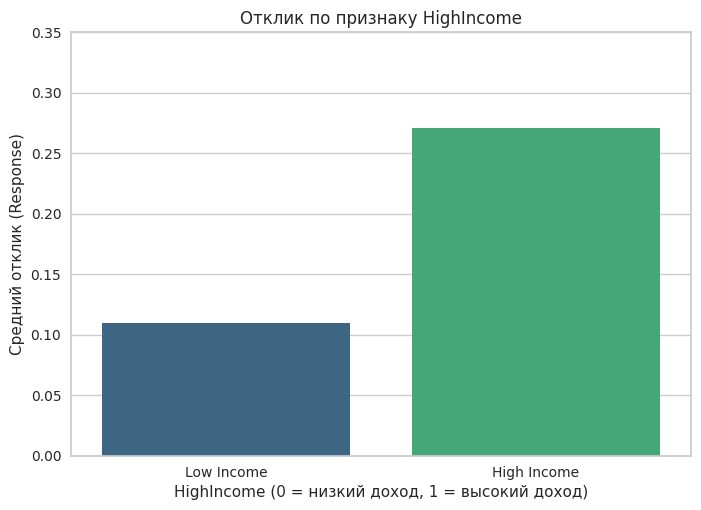

In [248]:
# Группируем данные
response_by_income = data.groupby('HighIncome')['Response'].mean().reset_index()

# Строим график
sns.barplot(x='HighIncome', y='Response', data=response_by_income, palette='viridis')

# Оформление
plt.title('Отклик по признаку HighIncome')
plt.xlabel('HighIncome (0 = низкий доход, 1 = высокий доход)')
plt.ylabel('Средний отклик (Response)')
plt.ylim(0, 0.35)  # Чтобы лучше видеть разницу
plt.xticks([0, 1], ['Low Income', 'High Income'])

plt.show()

Высокий доход → выше вероятность отклика
27.2% откликнувшихся среди группы с самым высоким доходом — это значительно больше, чем у остальных групп.
IncomeGroup — сильный предиктор
Если Income >= 68 118 шансы отклика вырастают
Высокий доход существенно увеличивает вероятность отклика Клиенты с доходом выше 68 118 откликаются на кампанию почти в 2,5 раза чаще (27.06% против 10.95%).
Основываясь на этих данных, стоит выделить клиентов с высоким доходом как более перспективную целевую аудиторию для дальнейших маркетинговых кампаний.
Клиенты с высоким доходом (HighIncome = 1) откликаются более чем в 2.5 раза чаще, чем клиенты с низким доходом.

## TotalPurchaseActivity - НА SHAP ГРАФИКЕ ПОКАЗАЛ ЛИНЕЙНУЮ ЗАВИСИМОСТЬ ОТ  LogTotalSpent!

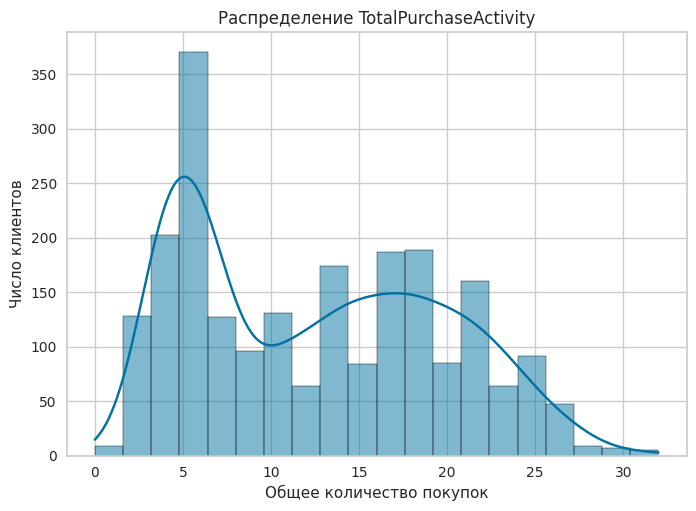

In [249]:
sns.histplot(data['TotalPurchaseActivity'], bins=20, kde=True)
plt.title("Распределение TotalPurchaseActivity")
plt.xlabel("Общее количество покупок")
plt.ylabel("Число клиентов")
plt.show()

Интерпретация графика:
- Первый пик около 5-6 покупок - это неактивные покупатели
- Второй пик 15-20 покупок - это активные покупатели
- Длинный хвост вправо - это супер активные покупатели

In [250]:
# # Разделяю на категории по порогам активности покупателей
def classify_activity(x):
    if x <= 6:
        return 'Low'
    elif x <= 13:
        return 'Medium'
    elif x <= 20:
        return 'High'
    else:
        return 'Super High'

data['ActivityLevel'] = data['TotalPurchaseActivity'].apply(classify_activity)

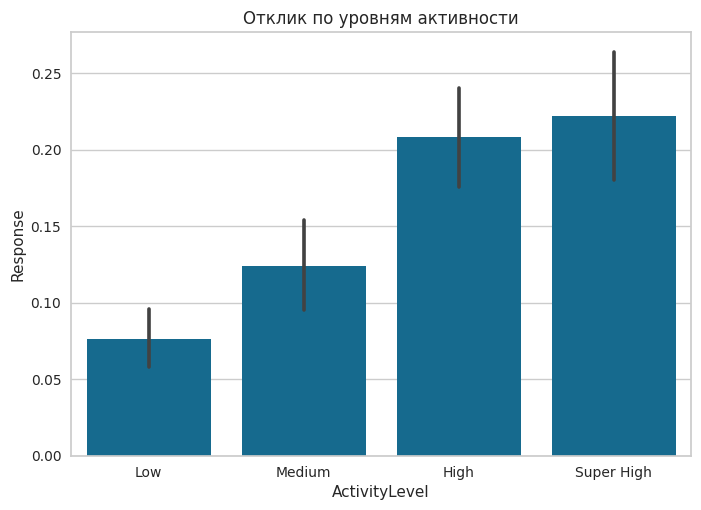

In [251]:
sns.barplot(x='ActivityLevel', y='Response', data=data, order=['Low', 'Medium', 'High', 'Super High'])
plt.title('Отклик по уровням активности')
plt.show()

In [252]:
response_by_activity = data.groupby('ActivityLevel')['Response'].mean().sort_index()
print(response_by_activity)

ActivityLevel
High         0.208074534161
Low          0.076163610719
Medium       0.123732251521
Super High   0.221932114883
Name: Response, dtype: float64


In [253]:
# # Создаю бинарную фичу HighActivity на основе ActivityLevel
data['HighActivity'] = data['ActivityLevel'].isin(['High', 'Super High']).astype(int)

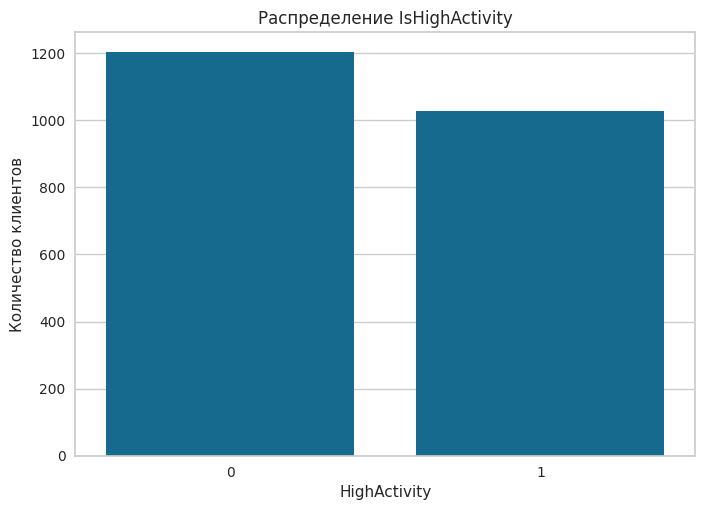

In [254]:
sns.countplot(x='HighActivity', data=data)
plt.title('Распределение IsHighActivity')
plt.xlabel('HighActivity')
plt.ylabel('Количество клиентов')
plt.show()

In [255]:
response_by_activity = data.groupby('HighActivity')['Response'].mean()
print(response_by_activity)

HighActivity
0   0.095673876872
1   0.213242453749
Name: Response, dtype: float64


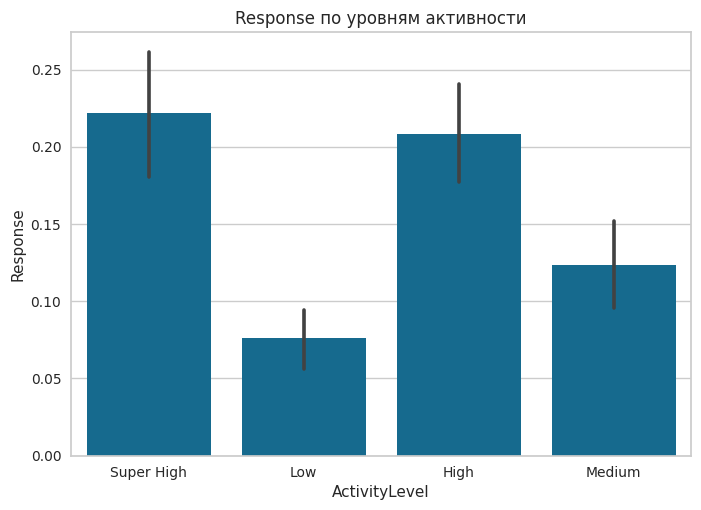

In [256]:
# # Действительно ли супер активные клиенты чаще откликаются?
sns.barplot(data=data, x='ActivityLevel', y='Response')
plt.title("Response по уровням активности")
plt.show()

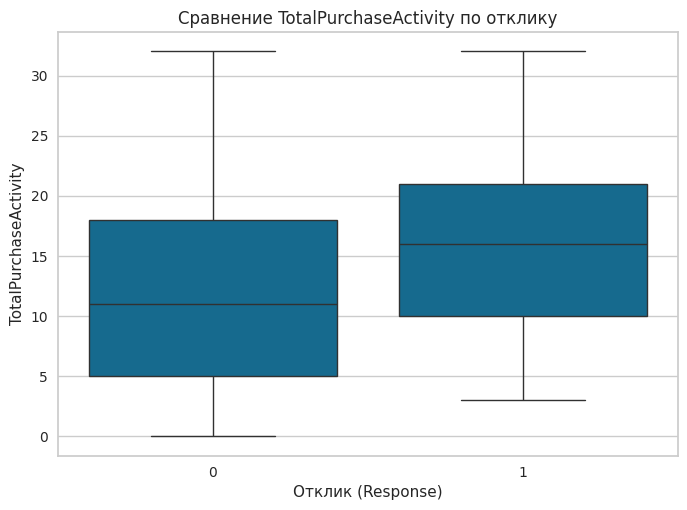

In [257]:
sns.boxplot(x='Response', y='TotalPurchaseActivity', data=data)
plt.title('Сравнение TotalPurchaseActivity по отклику')
plt.xlabel('Отклик (Response)')
plt.ylabel('TotalPurchaseActivity')
plt.show()

In [258]:
# Cоздаю бинарный флаг IsHighlyActive
data['IsHighlyActive'] = data['ActivityLevel'].isin(['High', 'Super High']).astype(int)

## TotalAcceptedCmp

In [259]:
data['TotalAcceptedCmp'].unique()

array([0, 1, 2, 3, 4])

In [260]:
data['TotalAcceptedCmp'].describe()

count             2229
mean    0.298788694482
std      0.67959709572
min                  0
25%                  0
50%                  0
75%                  0
max                  4
Name: TotalAcceptedCmp, dtype: float64

In [261]:
data.groupby(data['TotalAcceptedCmp'] > 0)['Response'].mean()

TotalAcceptedCmp
False   0.082625919638
True    0.406926406926
Name: Response, dtype: float64

In [262]:
# Создаю бинарный признак 
data['IsAcceptedBefore'] = (data['TotalAcceptedCmp'] > 0).astype(int)

In [263]:
response_total_accepted = data.groupby('Response')['TotalAcceptedCmp'].mean()
print(response_total_accepted)

Response
0   0.177308707124
1   0.988023952096
Name: TotalAcceptedCmp, dtype: float64


In [264]:
data['IsAcceptedBefore'].value_counts(normalize=True) * 100

IsAcceptedBefore
0   79.273216689098
1   20.726783310902
Name: proportion, dtype: float64

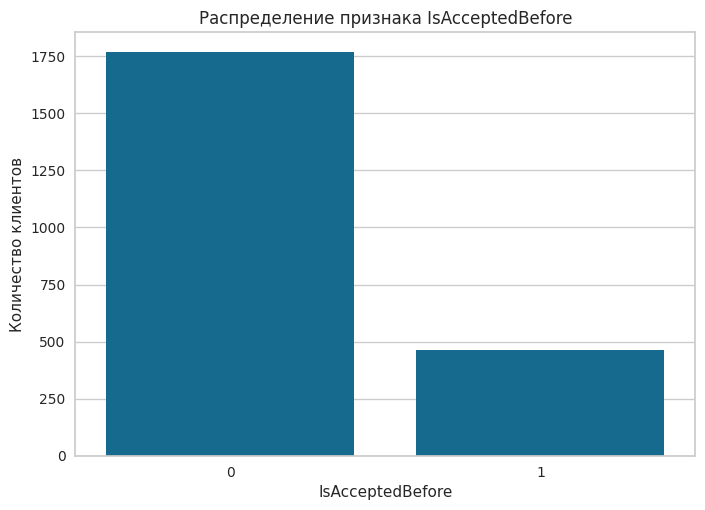

In [265]:
sns.countplot(x='IsAcceptedBefore', data=data)
plt.title('Распределение признака IsAcceptedBefore')
plt.xlabel('IsAcceptedBefore')
plt.ylabel('Количество клиентов')
plt.show()

## LogTotalSpentRounded- ДЛЯ ПРОСМОТРА ГРАФИКОВ И АНАЛИЗА. В ОБУЧЕНИЕ БЕРУ ПРИЗНАК LogTotalSpent

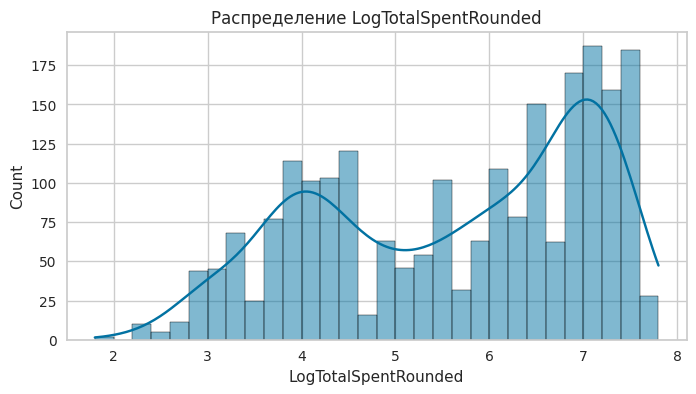

In [266]:
plt.figure(figsize=(8,4))
sns.histplot(data['LogTotalSpentRounded'], bins=30, kde=True)
plt.title('Распределение LogTotalSpentRounded')
plt.xlabel('LogTotalSpentRounded')
plt.show()

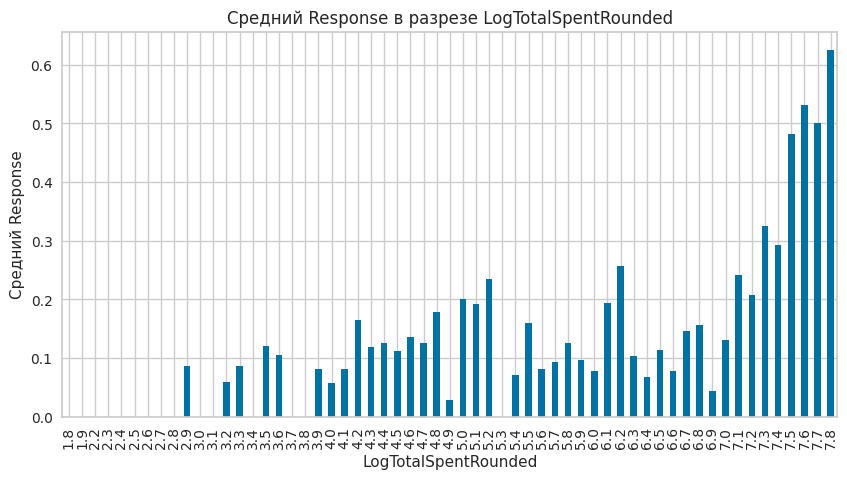

In [267]:
# # Группируем по округленному логарифму и считаем средний отклик
response_by_logspent = data.groupby('LogTotalSpentRounded')['Response'].mean()

plt.figure(figsize=(10,5))
response_by_logspent.plot(kind='bar')
plt.title('Средний Response в разрезе LogTotalSpentRounded')
plt.xlabel('LogTotalSpentRounded')
plt.ylabel('Средний Response')
plt.show()

## NumWebVisitsMonth

In [268]:
data['NumWebVisitsMonth'].describe()

count             2229
mean     5.33423059668
std     2.414981498852
min                  0
25%                  3
50%                  6
75%                  7
max                 20
Name: NumWebVisitsMonth, dtype: float64

- Большинство покупателей заходят на сайт 3-7 раз в месяц.
- Есть выбросы - до 20 посещений.

In [269]:
# Группируем и считаем средний Response
web_visits_response = data.groupby('NumWebVisitsMonth')['Response'].mean().reset_index()

# Переименуем столбцы для читаемости
web_visits_response.columns = ['NumWebVisitsMonth', 'MeanResponse']

# Выводим таблицу
print(web_visits_response)

    NumWebVisitsMonth   MeanResponse
0                   0              0
1                   1 0.201342281879
2                   2  0.19801980198
3                   3 0.160975609756
4                   4 0.119815668203
5                   5 0.089285714286
6                   6 0.141592920354
7                   7 0.114503816794
8                   8 0.166666666667
9                   9 0.349397590361
10                 10 0.333333333333
11                 13              0
12                 14              0
13                 17              0
14                 19              0
15                 20              0


<Axes: xlabel='NumWebVisitsMonth'>

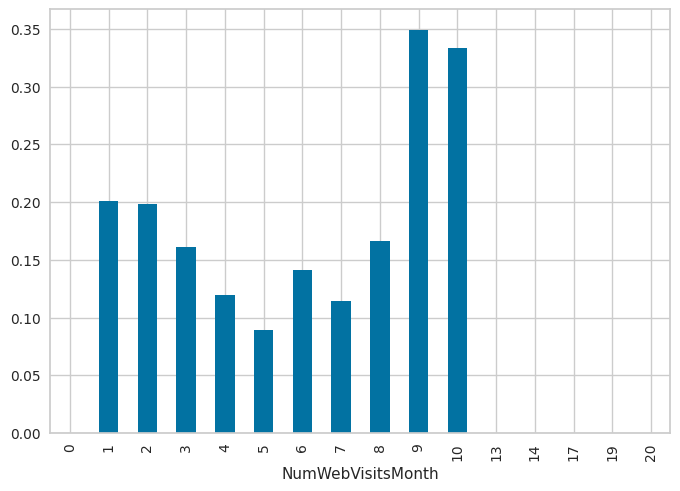

In [270]:
data.groupby('NumWebVisitsMonth')['Response'].mean().plot(kind='bar')

In [271]:
data['NumWebVisitsMonth'].max()

20

In [272]:
data[data['NumWebVisitsMonth'] == 20][['NumWebVisitsMonth', 'Response']]

,NumWebVisitsMonth,Response
9,20,0
774,20,0
1245,20,0


In [273]:
data['NumWebVisitsMonth'].value_counts().sort_index()

NumWebVisitsMonth
0       7
1     149
2     202
3     205
4     217
5     280
6     339
7     393
8     342
9      83
10      3
13      1
14      2
17      1
19      2
20      3
Name: count, dtype: int64

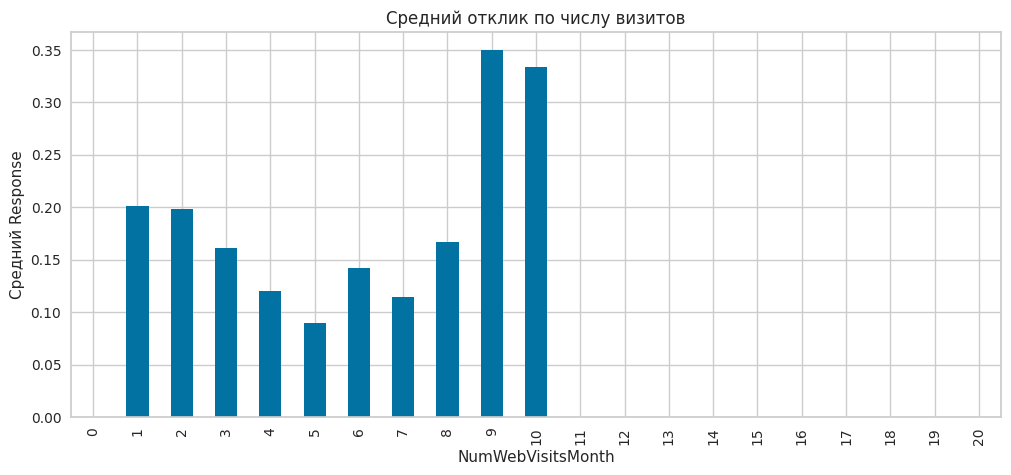

In [274]:
# Явная группировка + заполнение пропущенных значений
response_by_visits = data.groupby('NumWebVisitsMonth')['Response'].mean()

# Добавим отсутствующие значения (например, от 0 до 20)
response_by_visits = response_by_visits.reindex(range(0, 21), fill_value=0)

# Строим график
response_by_visits.plot(kind='bar', figsize=(12, 5), title='Средний отклик по числу визитов')
plt.xlabel('NumWebVisitsMonth')
plt.ylabel('Средний Response')
plt.show()

In [275]:
# Cоздаю бины по активности на сайте
def web_visit_segment(x):
    if x == 0:
        return 'No Visits'
    elif x <= 2:
        return 'Effective'
    elif x <= 7:
        return 'Passive'
    elif x <= 10:
        return 'High Traffic'
    else:
        return 'Anomaly'

In [276]:
data['WebVisitSegment'] = data['NumWebVisitsMonth'].apply(web_visit_segment)

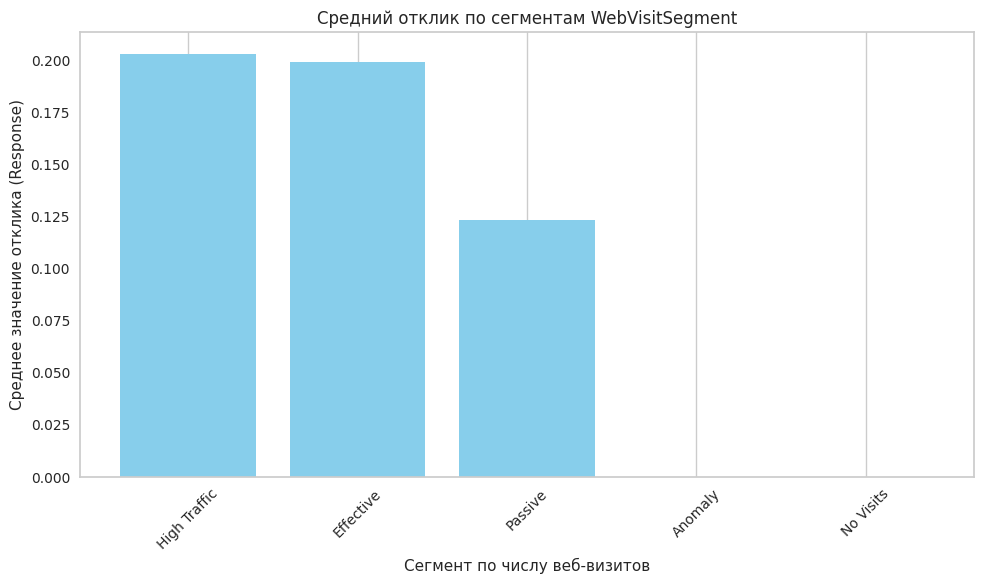

,WebVisitSegment,Response
2,High Traffic,0.203
1,Effective,0.199
4,Passive,0.123
0,Anomaly,0
3,No Visits,0


In [277]:
# Группируем и рассчитываем средний отклик
segment_response = data.groupby('WebVisitSegment')['Response'].mean().reset_index().sort_values(by='Response', ascending=False)

# Построим график
plt.figure(figsize=(10, 6))
plt.bar(segment_response['WebVisitSegment'], segment_response['Response'], color='skyblue')
plt.title('Средний отклик по сегментам WebVisitSegment')
plt.ylabel('Среднее значение отклика (Response)')
plt.xlabel('Сегмент по числу веб-визитов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Покажем таблицу тоже
segment_response.round(3)

In [278]:
data['HightWebVisitor'] = data['WebVisitSegment'].isin(['High Traffic', 'Effective']).astype(int)

In [279]:
data.head(2)

,Income,Recency,NumWebVisitsMonth,Response,Age,HasChildren,MaritalFlag,TotalPurchaseActivity,TotalAcceptedCmp,HigherEducation,...,LogTotalSpentRounded,RecencyGroup,IncomeGroup,HighIncome,ActivityLevel,HighActivity,IsHighlyActive,IsAcceptedBefore,WebVisitSegment,HightWebVisitor
0,58138,58,7,1,68,0,0,22,0,1,...,7.4,41-60,Mid-High,0,Super High,1,1,0,Passive,0
1,46344,38,5,0,71,1,0,4,0,1,...,3.3,21-40,Mid-Low,0,Low,0,0,0,Passive,0


## HigherEducation-малоинформативный признак для модели

In [280]:
# Распределение данных
data['HigherEducation'].value_counts(normalize=True)

HigherEducation
1   0.885598923284
0   0.114401076716
Name: proportion, dtype: float64

In [281]:
data.groupby('HigherEducation')['Response'].mean()

HigherEducation
0   0.094117647059
1    0.15704154002
Name: Response, dtype: float64

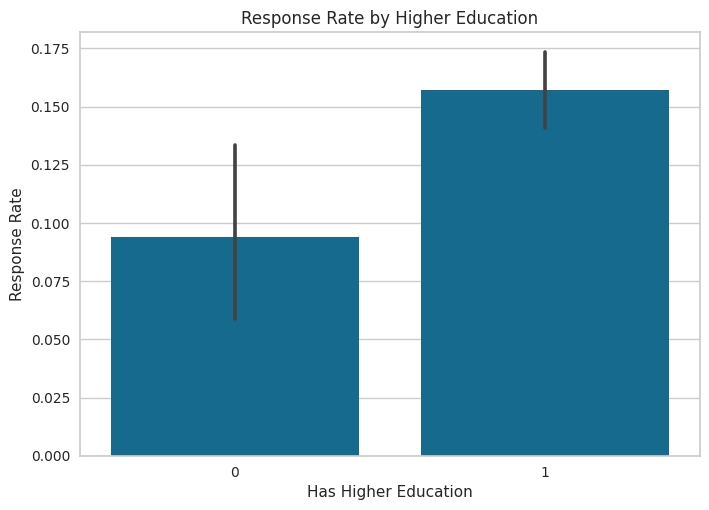

In [282]:
sns.barplot(x='HigherEducation', y='Response', data=data)
plt.xlabel('Has Higher Education')
plt.ylabel('Response Rate')
plt.title('Response Rate by Higher Education')
plt.show()

In [283]:
data.head(2)

,Income,Recency,NumWebVisitsMonth,Response,Age,HasChildren,MaritalFlag,TotalPurchaseActivity,TotalAcceptedCmp,HigherEducation,...,LogTotalSpentRounded,RecencyGroup,IncomeGroup,HighIncome,ActivityLevel,HighActivity,IsHighlyActive,IsAcceptedBefore,WebVisitSegment,HightWebVisitor
0,58138,58,7,1,68,0,0,22,0,1,...,7.4,41-60,Mid-High,0,Super High,1,1,0,Passive,0
1,46344,38,5,0,71,1,0,4,0,1,...,3.3,21-40,Mid-Low,0,Low,0,0,0,Passive,0


In [284]:
features_2 = ['Recency', 'Age', 'HasChildren', 'MaritalFlag', 'HigherEducation', 'LogTotalSpent', 'HighIncome', 'IsAcceptedBefore', 'HightWebVisitor']

X = data[features_2]
y = data['Response']

In [285]:
def fit_catboost_model(X, y, features=None):
    X_filtered = X[features] if features else X

    # Расчет весов классов (пример с бинарной классификацией)
    class_counts = y.value_counts()
    total = len(y)
    class_weights = [total / class_counts[cls] for cls in sorted(class_counts.index)]

    model = CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.1,
        verbose=False,
        class_weights=class_weights
    )

    model.fit(X_filtered, y)

    feature_importance = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': X_filtered.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    y_pred = model.predict(X_filtered)

    display(feature_importance_df)

    return model

In [286]:
_ = fit_catboost_model(X, y)

,Feature,Importance
5,LogTotalSpent,27.974034890918
0,Recency,23.665036384265
1,Age,18.729704525638
7,IsAcceptedBefore,9.367451598767
3,MaritalFlag,6.436357520715
8,HightWebVisitor,6.206009777353
2,HasChildren,4.385024866314
6,HighIncome,1.85829297217
4,HigherEducation,1.378087463861


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


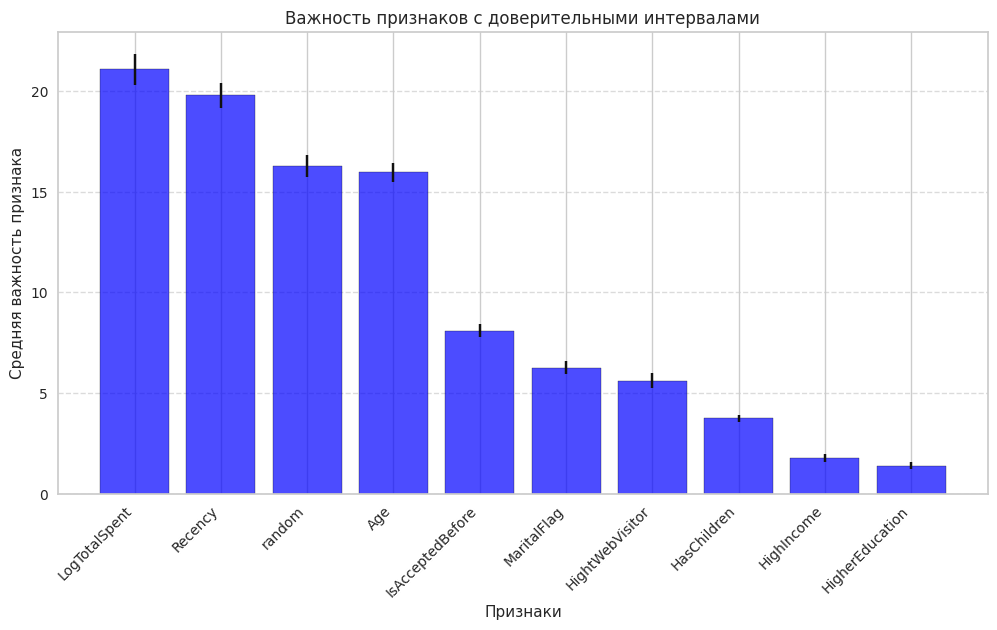

In [287]:
n_iterations = 10
features = list(X.columns) + ['random']

# Словарь для хранения значений важности признаков
feature_importance_records = {feature: [] for feature in features}

# Запускаем обучение много раз
for _ in tqdm(range(n_iterations)):
    X['random'] = np.random.random(size=len(X))
    model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
    model.fit(X, y)

    # Получаем важность признаков
    feature_importance = model.feature_importances_

    # Записываем значения в словарь
    for feature, importance in zip(X.columns, feature_importance):
        feature_importance_records[feature].append(importance)

# Создаём DataFrame с итоговыми средними и стандартными отклонениями
feature_importance_stats = pd.DataFrame({
    'feature': list(feature_importance_records.keys()),
    'mean': [np.mean(values) for values in feature_importance_records.values()],
    'std': [np.std(values) for values in feature_importance_records.values()]
}).sort_values(by='mean', ascending=False)

# display(feature_importance_stats)

plt.figure(figsize=(12, 6))
plt.bar(
    feature_importance_stats['feature'], 
    feature_importance_stats['mean'], 
    yerr=feature_importance_stats['std'], 
    capsize=5, 
    color='blue', 
    edgecolor='black', 
    alpha=0.7
)

plt.xlabel('Признаки')
plt.ylabel('Средняя важность признака')
plt.title('Важность признаков с доверительными интервалами')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение графика
plt.show()

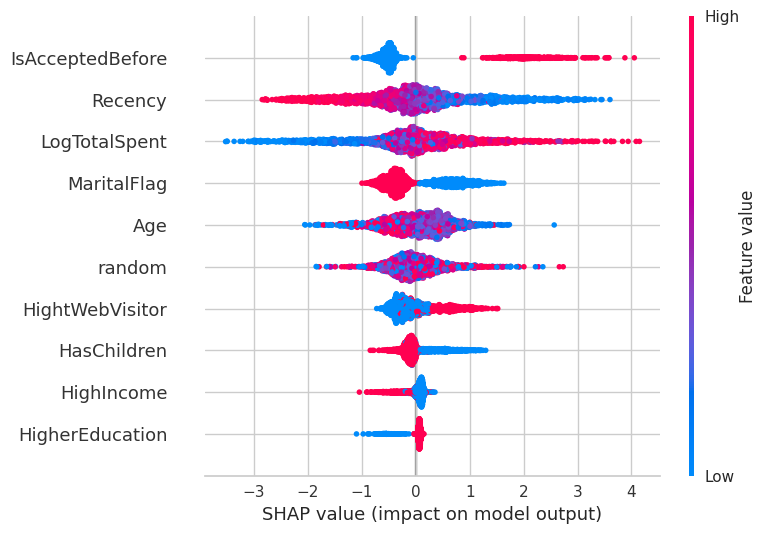

In [288]:
# Обучаем модель
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
model.fit(X, y)

# Инициализируем SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# SHAP summary plot
shap.summary_plot(shap_values, X)

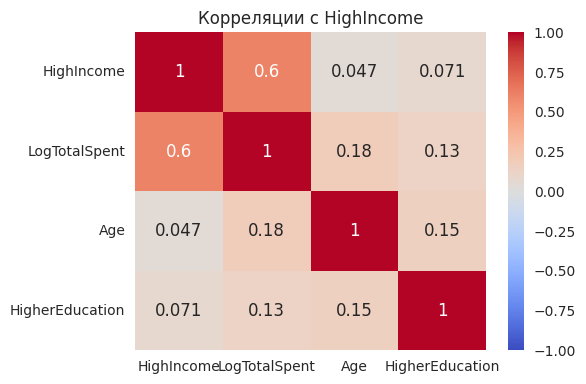

In [289]:
# Список признаков для анализа
features_to_check_2 = ['HighIncome', 'LogTotalSpent', 'Age', 'HigherEducation']

# Вычисляем корреляционную матрицу
corr_matrix = data[features_to_check_2].corr()

# Визуализируем
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляции с HighIncome')
plt.tight_layout()
plt.show()

In [290]:
print(corr_matrix)

                    HighIncome  LogTotalSpent            Age  HigherEducation
HighIncome                   1 0.604046708297 0.046708490029   0.071044457708
LogTotalSpent   0.604046708297              1 0.175344842612   0.129280352603
Age             0.046708490029 0.175344842612              1   0.149844998356
HigherEducation 0.071044457708 0.129280352603 0.149844998356                1


HighIncome и LogTotalSpent - cамая сильная корреляция в таблице. Люди с высоким доходом, как правило, тратят больше денег — логично

## Age - под вопросом, нужно смотреть взаимодействие с другими признаками

In [291]:
# Функция для категоризации возрвста
def age_segment(age):
    if 20 <= age <= 39:
        return 'Young'
    elif 40 <= age <= 59:
        return 'Middle-aged'
    elif 60 <= age <= 86:
        return 'Old'

In [292]:
# Применяем функцию к столбцу Age
data['AgeSegment'] = data['Age'].apply(age_segment)

In [293]:
print(data['AgeSegment'].value_counts())

AgeSegment
Middle-aged    1184
Old             856
Young           189
Name: count, dtype: int64


In [294]:
print(data.groupby('AgeSegment')['Response'].mean())

AgeSegment
Middle-aged   0.154560810811
Old           0.139018691589
Young         0.169312169312
Name: Response, dtype: float64


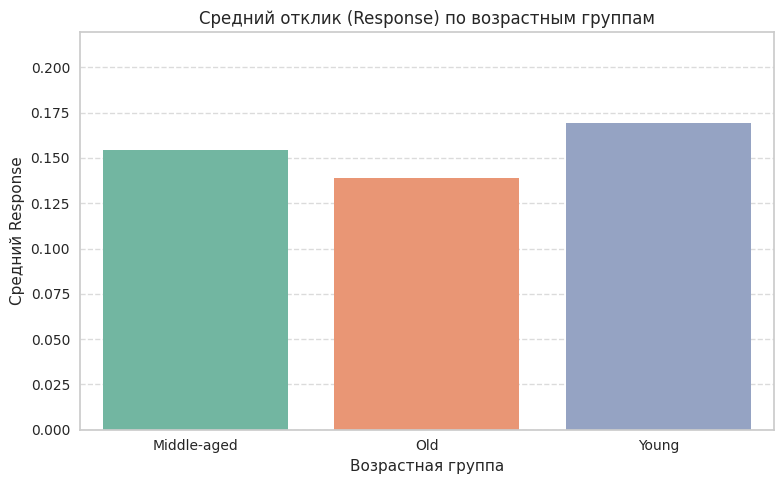

In [295]:
# Группируем данные
age_response = data.groupby('AgeSegment')['Response'].mean().reset_index()

# Строим график
plt.figure(figsize=(8, 5))
sns.barplot(data=age_response, x='AgeSegment', y='Response', palette='Set2')
plt.title('Средний отклик (Response) по возрастным группам')
plt.ylabel('Средний Response')
plt.xlabel('Возрастная группа')
plt.ylim(0, age_response['Response'].max() + 0.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [296]:
data.head(2)

,Income,Recency,NumWebVisitsMonth,Response,Age,HasChildren,MaritalFlag,TotalPurchaseActivity,TotalAcceptedCmp,HigherEducation,...,RecencyGroup,IncomeGroup,HighIncome,ActivityLevel,HighActivity,IsHighlyActive,IsAcceptedBefore,WebVisitSegment,HightWebVisitor,AgeSegment
0,58138,58,7,1,68,0,0,22,0,1,...,41-60,Mid-High,0,Super High,1,1,0,Passive,0,Old
1,46344,38,5,0,71,1,0,4,0,1,...,21-40,Mid-Low,0,Low,0,0,0,Passive,0,Old


## Взаимосвязь признаков c Age

### Age и HighIncome

In [297]:
# Группирую по  AgeSegment и HighIncome
data.groupby(['AgeSegment', 'HighIncome'])['Response'].mean()

AgeSegment   HighIncome
Middle-aged  0            0.117395944504
             1            0.295546558704
Old          0             0.10396039604
             1                     0.224
Young        0                  0.078125
             1            0.360655737705
Name: Response, dtype: float64

Разница между группами по доходу внутри каждого возрастного сегмента достаточно большая, значит взаимодействие этих двух признаков информативно.

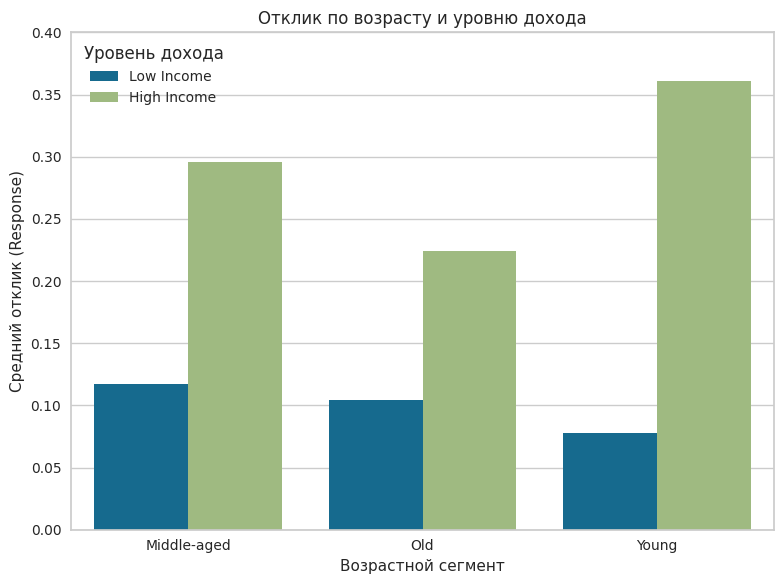

In [298]:
# Вывожу график
grouped = data.groupby(['AgeSegment', 'HighIncome'])['Response'].mean().reset_index()

# Заменяю HighIncome на уровень дохода
grouped['IncomeGroup'] = grouped['HighIncome'].map({0: 'Low Income', 1: 'High Income'})

plt.figure(figsize=(8, 6))
sns.barplot(data=grouped, x='AgeSegment', y='Response', hue='IncomeGroup')

plt.title('Отклик по возрасту и уровню дохода')
plt.ylabel('Средний отклик (Response)')
plt.xlabel('Возрастной сегмент')
plt.legend(title='Уровень дохода')
plt.ylim(0, 0.4)
plt.tight_layout()
plt.show()

In [299]:
data['YoungHighIncome'] = ((data['AgeSegment'] == 'Young') & (data['HighIncome'] == 1)).astype(int)

In [300]:
pd.crosstab(data['YoungHighIncome'], data['Response'], normalize='index')

Response,0,1
YoungHighIncome,,
0,0.856088560886,0.143911439114
1,0.639344262295,0.360655737705


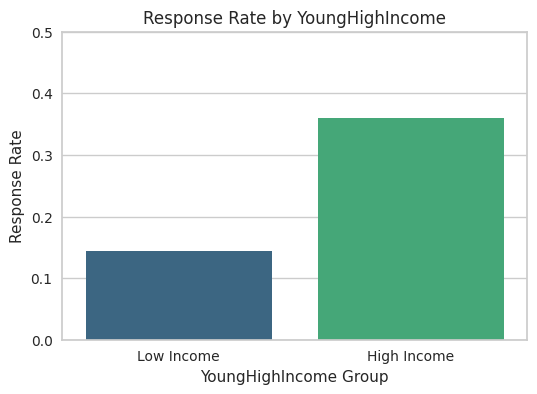

In [301]:
# Считаем долю отклика по группам YoungHighIncome
response_rate = data.groupby('YoungHighIncome')['Response'].mean().reset_index()

# Переименуем для красоты
response_rate.columns = ['YoungHighIncome', 'ResponseRate']

# Визуализация
plt.figure(figsize=(6,4))
sns.barplot(x='YoungHighIncome', y='ResponseRate', data=response_rate, palette='viridis')

plt.xticks([0,1], ['Low Income', 'High Income'])
plt.ylim(0, 0.5)
plt.title('Response Rate by YoungHighIncome')
plt.ylabel('Response Rate')
plt.xlabel('YoungHighIncome Group')
plt.show()

### AgeSegment и ActivityLevel

In [302]:
data.groupby(['AgeSegment', 'ActivityLevel'])['Response'].mean()

AgeSegment   ActivityLevel
Middle-aged  High            0.221122112211
             Low             0.098901098901
             Medium          0.134920634921
             Super High      0.212643678161
Old          High            0.181506849315
             Low             0.027777777778
             Medium          0.112195121951
             Super High      0.212290502793
Young        High            0.285714285714
             Low             0.054054054054
             Medium          0.111111111111
             Super High      0.333333333333
Name: Response, dtype: float64

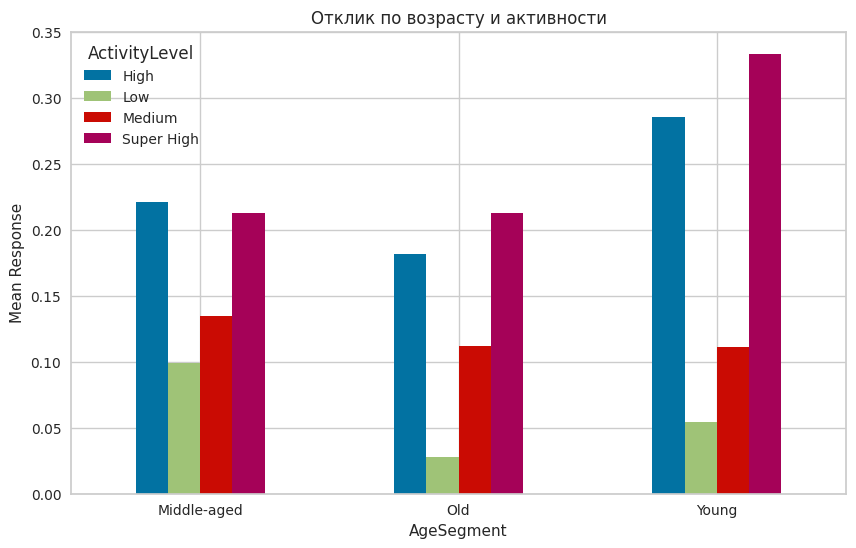

In [303]:
pivot = data.groupby(['AgeSegment', 'ActivityLevel'])['Response'].mean().unstack()
pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Отклик по возрасту и активности')
plt.ylabel('Mean Response')
plt.xticks(rotation=0)
plt.legend(title='ActivityLevel')
plt.show()

In [304]:
def age_activity_segment(row):
    if row['AgeSegment'] == 'Young' and row['ActivityLevel'] in ['High', 'Super High']:
        return 'Young-Active'
    elif row['AgeSegment'] == 'Old' and row['ActivityLevel'] == 'Low':
        return 'Old-Inactive'
    else:
        return 'Other'

data['AgeActivitySegment'] = data.apply(age_activity_segment, axis=1)

In [305]:
data.groupby('AgeActivitySegment')['Response'].mean()

AgeActivitySegment
Old-Inactive   0.027777777778
Other          0.154822335025
Young-Active   0.303797468354
Name: Response, dtype: float64

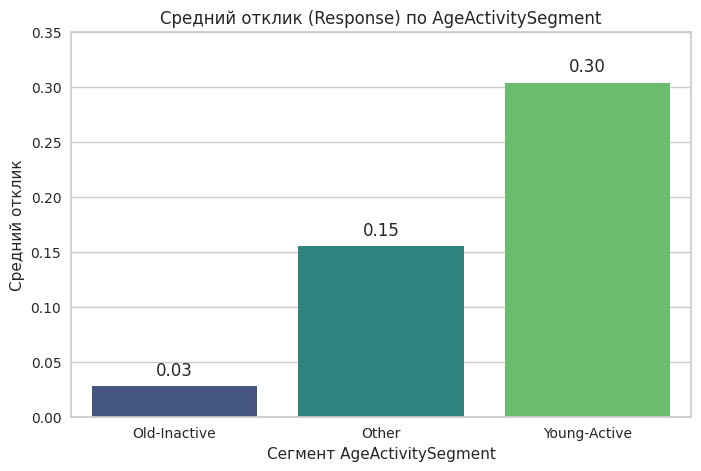

In [306]:
# Группирую и считаю средний отклик
response_by_segment = data.groupby('AgeActivitySegment')['Response'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=response_by_segment, x='AgeActivitySegment', y='Response', palette='viridis')

plt.title('Средний отклик (Response) по AgeActivitySegment')
plt.ylabel('Средний отклик')
plt.xlabel('Сегмент AgeActivitySegment')
plt.ylim(0, 0.35) 

# Подписываю значения над столбцами
for index, row in response_by_segment.iterrows():
    plt.text(index, row.Response + 0.01, f"{row.Response:.2f}", ha='center')

plt.show()

In [307]:
pd.crosstab(data['AgeActivitySegment'], data['Response'], normalize='index')

Response,0,1
AgeActivitySegment,,
Old-Inactive,0.972222222222,0.027777777778
Other,0.845177664975,0.154822335025
Young-Active,0.696202531646,0.303797468354


Young-Active — самый высокий уровень отклика (30.4%). Это потенциально самая ценная группа для маркетинга.

In [308]:
#Преобразую в бинарный вид
data['IsYoungActive'] = (data['AgeActivitySegment'] == 'Young-Active').astype(int)

In [309]:
data.head(2)

,Income,Recency,NumWebVisitsMonth,Response,Age,HasChildren,MaritalFlag,TotalPurchaseActivity,TotalAcceptedCmp,HigherEducation,...,ActivityLevel,HighActivity,IsHighlyActive,IsAcceptedBefore,WebVisitSegment,HightWebVisitor,AgeSegment,YoungHighIncome,AgeActivitySegment,IsYoungActive
0,58138,58,7,1,68,0,0,22,0,1,...,Super High,1,1,0,Passive,0,Old,0,Other,0
1,46344,38,5,0,71,1,0,4,0,1,...,Low,0,0,0,Passive,0,Old,0,Old-Inactive,0


## Feature eng_3

In [310]:
#Смотрю feture eng на полученныхз признаках
features_3 = ['Recency', 'HasChildren', 'MaritalFlag', 'Age', 'HigherEducation', 'LogTotalSpent',  
            'IsHighlyActive',
            'IsAcceptedBefore', 'HightWebVisitor', 'YoungHighIncome', 'IsYoungActive' ]
        
X = data[features_3]
y = data['Response']

In [311]:
def fit_catboost_model(X, y, features=None):
    X_filtered = X[features] if features else X

    # Расчет весов классов (пример с бинарной классификацией)
    class_counts = y.value_counts()
    total = len(y)
    class_weights = [total / class_counts[cls] for cls in sorted(class_counts.index)]

    model = CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.1,
        verbose=False,
        class_weights=class_weights
    )

    model.fit(X_filtered, y)

    feature_importance = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': X_filtered.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    y_pred = model.predict(X_filtered)

    display(feature_importance_df)

    return model

In [312]:
_ = fit_catboost_model(X, y)

,Feature,Importance
5,LogTotalSpent,27.776256302908
0,Recency,24.069056682059
3,Age,18.910673281937
7,IsAcceptedBefore,9.390733177877
8,HightWebVisitor,6.338874806935
2,MaritalFlag,6.292697901538
1,HasChildren,4.220992453702
4,HigherEducation,1.530761112619
6,IsHighlyActive,1.233602132596
9,YoungHighIncome,0.151433549333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.07it/s]


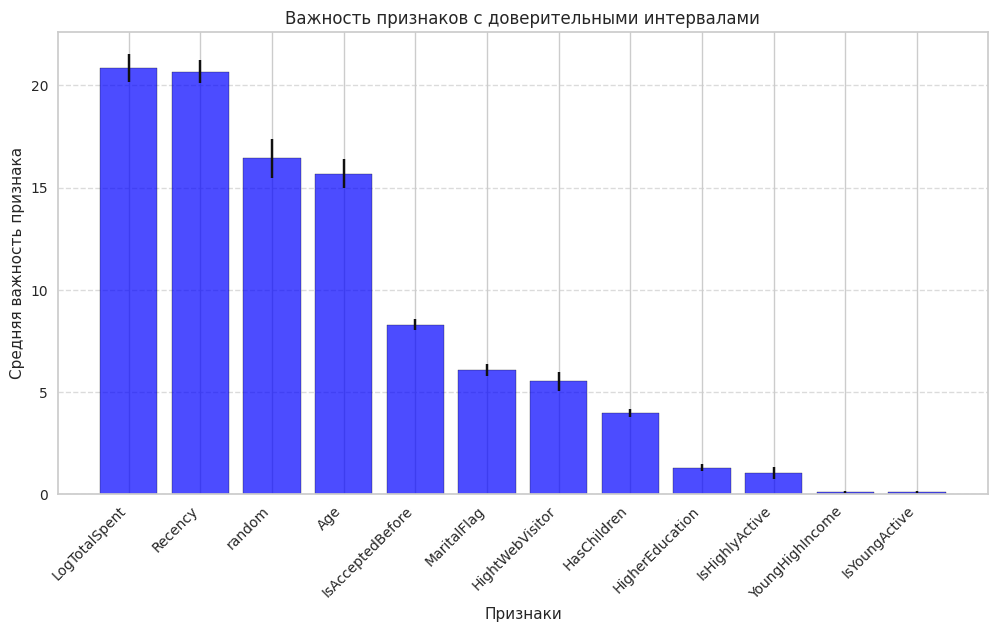

In [313]:
n_iterations = 10
features = list(X.columns) + ['random']

# Словарь для хранения значений важности признаков
feature_importance_records = {feature: [] for feature in features}

# Запускаем обучение много раз
for _ in tqdm(range(n_iterations)):
    X['random'] = np.random.random(size=len(X))
    model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
    model.fit(X, y)

    # Получаем важность признаков
    feature_importance = model.feature_importances_

    # Записываем значения в словарь
    for feature, importance in zip(X.columns, feature_importance):
        feature_importance_records[feature].append(importance)

# Создаём DataFrame с итоговыми средними и стандартными отклонениями
feature_importance_stats = pd.DataFrame({
    'feature': list(feature_importance_records.keys()),
    'mean': [np.mean(values) for values in feature_importance_records.values()],
    'std': [np.std(values) for values in feature_importance_records.values()]
}).sort_values(by='mean', ascending=False)

# display(feature_importance_stats)

plt.figure(figsize=(12, 6))
plt.bar(
    feature_importance_stats['feature'], 
    feature_importance_stats['mean'], 
    yerr=feature_importance_stats['std'], 
    capsize=5, 
    color='blue', 
    edgecolor='black', 
    alpha=0.7
)

plt.xlabel('Признаки')
plt.ylabel('Средняя важность признака')
plt.title('Важность признаков с доверительными интервалами')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение графика
plt.show()

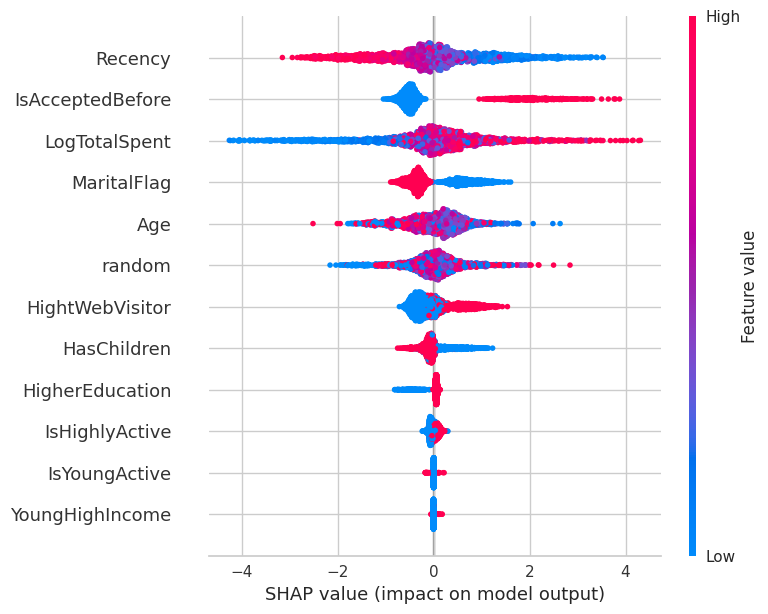

In [314]:
# Обучаем модель
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
model.fit(X, y)

# Инициализируем SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# SHAP summary plot
shap.summary_plot(shap_values, X)

In [315]:
data.head(2)

,Income,Recency,NumWebVisitsMonth,Response,Age,HasChildren,MaritalFlag,TotalPurchaseActivity,TotalAcceptedCmp,HigherEducation,...,ActivityLevel,HighActivity,IsHighlyActive,IsAcceptedBefore,WebVisitSegment,HightWebVisitor,AgeSegment,YoungHighIncome,AgeActivitySegment,IsYoungActive
0,58138,58,7,1,68,0,0,22,0,1,...,Super High,1,1,0,Passive,0,Old,0,Other,0
1,46344,38,5,0,71,1,0,4,0,1,...,Low,0,0,0,Passive,0,Old,0,Old-Inactive,0


По результатам feature selection оставляю более информативные признаки:
- IsAcceptedBefore
- Recency
- LogTotalSpent
- HighWebVisitor
- MaritalFlag
- HasChildren

## Корреляция

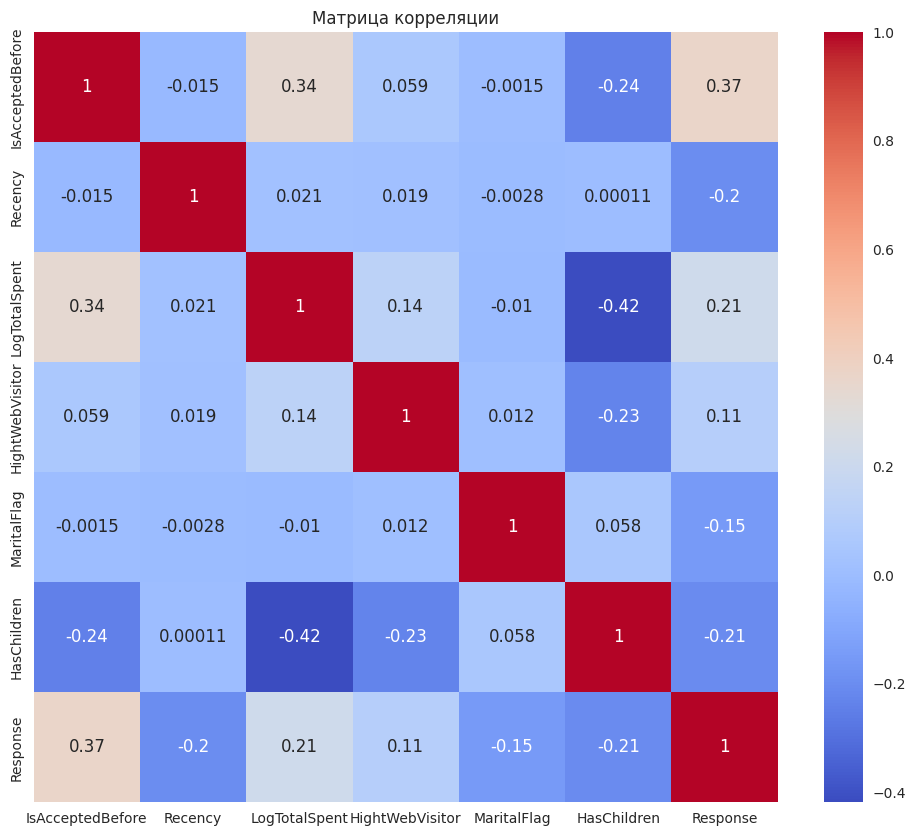

In [341]:
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.title("Матрица корреляции")
plt.show()

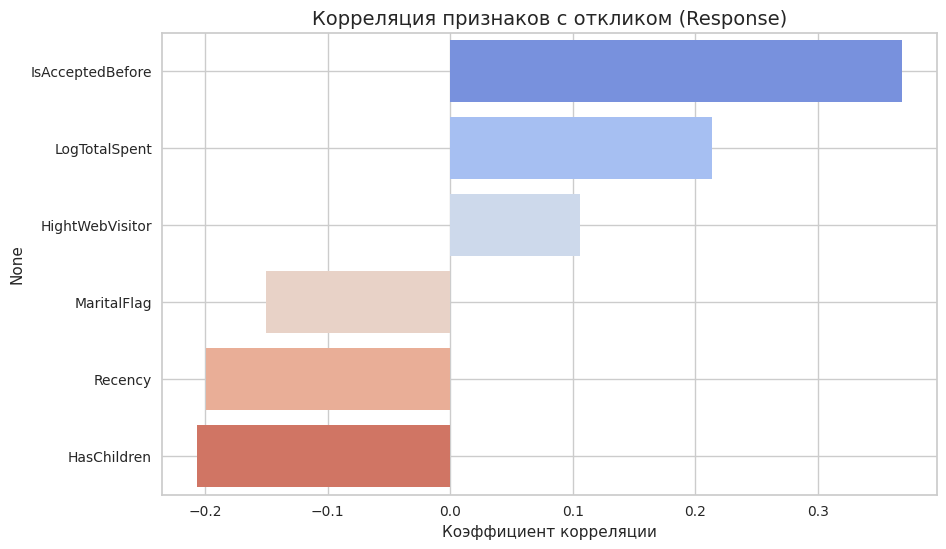

In [342]:
numeric_cols = data.select_dtypes(include='number') #Выбираю только числовые признаки
corr_matrix = numeric_cols.corr() #Строю матрицу
response_corr = corr_matrix["Response"].drop("Response").sort_values(ascending=False) #Вывожу только корреляции с Response
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.barplot(x=response_corr.values, y=response_corr.index, palette="coolwarm")
plt.title("Корреляция признаков с откликом (Response)", fontsize=14)
plt.xlabel("Коэффициент корреляции")
plt.grid(True)
plt.show()

In [343]:
print(response_corr)

IsAcceptedBefore    0.368306194453
LogTotalSpent       0.213824081164
HightWebVisitor     0.106166167706
MaritalFlag        -0.150113905547
Recency            -0.199077577707
HasChildren        -0.206690986209
Name: Response, dtype: float64


## Проверка гипотез

### IsAcceptedBefore

H₀: Средний Response одинаков у участвовавших ранее и не участвовавших

H₁: Средний Response различается

In [344]:
# Таблица сопряженности
contingency_table = pd.crosstab(data['IsAcceptedBefore'], data['Response'])
print(contingency_table)

Response             0    1
IsAcceptedBefore           
0                 1621  146
1                  274  188


In [346]:
# Chi²-тест
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi²-статистика: {chi2:.4f}")
print(f"P-значение: {p:.4f}")
if p < 0.05:
    print("Отклоняем H₀")
else:
    print("Не отклоняем H₀")

Chi²-статистика: 299.8223
P-значение: 0.0000
Отклоняем H₀


### Recency

H₀: Нет зависимости между давностью контакта и откликом

H₁: Зависимость есть

In [ ]:
#Тест: t-test / U-test

### LogTotalSpent

H₀: Средние значения LogTotalSpent одинаковы для откликнувшихся и неоткликнувшихся

H₁: Различаются

In [ ]:
#Тест: t-test или U-test

###  HightWebVisitor

H₀: Веб-активность не влияет на Response

H₁: Влияет

In [ ]:
#Тест: χ² или t-test, в зависимости от типа данных

### MaritalFlag

H₀: Семейное положение не связано с откликом

H₁: Связано

In [ ]:
# Тест: χ²-критерий

### HasChildren

H₀: Наличие детей не влияет на Response

H₁: Влияет

In [ ]:
#Тест: χ² или t-test

### AgeSegment vs Response

H₀: Возрастной сегмент не влияет на вероятность отклика.

H₁: Некоторые возрастные группы откликаются чаще, чем другие

In [273]:
# Создаём таблицу сопряжённости
contingency_table = pd.crosstab(data['AgeSegment'], data['Response'])

# Применяем χ²-тест
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Выводим результаты
print(f"Chi²-статистика: {chi2:.4f}")
print(f"P-значение: {p:.4f}")
if p < 0.05:
    print("Отклоняем H₀- Т.е. возрастной сегмент влияет на вероятность отклика.")
else:
    print("Не отклоняем H₀- Нет статистически значимых различий в отклике между возрастными сегментами")

Chi²-статистика: 1.5565
P-значение: 0.4592
Не отклоняем H₀- Нет статистически значимых различий в отклике между возрастными сегментами


### HigherEducation vs Response

H₀: Наличие высшего образования не влияет на отклик.

H₁: Образованные клиенты чаще / реже откликаются на кампанию.

In [277]:
# Создаем таблицу сопряженности
contingency_table = pd.crosstab(data['HigherEducation'], data['Response'])

# Проводим χ²-тест
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi²-статистика: {chi2:.4f}")
print(f"P-значение: {p:.4f}")

if p < 0.05:
    print("Отклоняем H₀: наличие высшего образования связано с откликом.")
else:
    print("Нет оснований отклонять H₀: связь не обнаружена.")

Chi²-статистика: 6.5337
P-значение: 0.0106
Отклоняем H₀: наличие высшего образования связано с откликом.


### YoungHighIncome vs Response - вопрос!

H₀: Принадлежность к сегменту «молодые с высоким доходом» не влияет на отклик.

H₁: Сегмент «молодые и богатые» чаще откликается.

In [325]:
contingency_table = pd.crosstab(data['YoungHighIncome'], data['Response'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi²-статистика: {chi2:.4f}")
print(f"P-значение: {p:.4f}")

if p < 0.05:
    print("Отклоняем H₀: принадлежность к сегменту 'молодые с высоким доходом' влияет на отклик.")
else:
    print("Нет оснований отклонять H₀: связь не обнаружена.")

Chi²-статистика: 20.2112
P-значение: 0.0000
Отклоняем H₀: принадлежность к сегменту 'молодые с высоким доходом' влияет на отклик.


### IsYoungActive vs Response - вопрос!

H₀: Принадлежность к сегменту «молодые и активные» не влияет на отклик.

H₁: Сегмент «молодые и активные»  чаще откликается.

In [280]:
contingency_table = pd.crosstab(data['IsYoungActive'], data['Response'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi²-статистика: {chi2:.4f}")
print(f"P-значение: {p:.4f}")

if p < 0.05:
    print("Отклоняем H₀: принадлежность к сегменту 'молодые с высоким доходом' влияет на отклик.")
else:
    print("Нет оснований отклонять H₀: связь не обнаружена.")

Chi²-статистика: 14.0115
P-значение: 0.0002
Отклоняем H₀: принадлежность к сегменту 'молодые с высоким доходом' влияет на отклик.


In [326]:
data.head(3)

,Income,Recency,NumWebVisitsMonth,Response,Age,HasChildren,MaritalFlag,TotalPurchaseActivity,TotalAcceptedCmp,HigherEducation,...,ActivityLevel,HighActivity,IsHighlyActive,IsAcceptedBefore,WebVisitSegment,HightWebVisitor,AgeSegment,YoungHighIncome,AgeActivitySegment,IsYoungActive
0,58138,58,7,1,68,0,0,22,0,1,...,Super High,1,1,0,Passive,0,Old,0,Other,0
1,46344,38,5,0,71,1,0,4,0,1,...,Low,0,0,0,Passive,0,Old,0,Old-Inactive,0
2,71613,26,4,0,60,0,1,20,0,1,...,High,1,1,0,Passive,0,Old,0,Other,0


На основании проведенного EDA и проверки гипотез можно сделать следующие выводы:
- Покупатели с высоким доходом (HighIncome=1) чаще откликаются на кампанию
- Человек, который принимал участие в предыдущих кампаниях(IsAcceptedBefore=1) с большей вероятностью примет участие и в будущей кампании
- Возрастной сегмент(AgeSegment) не влияет на вероятность отклика
- Клиенты с высокой веб-активностью(HightWebVisitor=1) чаще откликаются
- Наличие высшего образования(HigherEducation=1) связано с откликом
- Сегмент «молодые и богатые»(YoungHighIncome=1) чаще откликается
- Сегмент «молодые и активные»(IsYoungActive=1) чаще откликается
- Покупатели с детьми(HasChildren=1) реже откликаются на маркетинговые компании
- Женатые/замужние покупатели(MaritalFlag=1) реже откликаются на маркетинговые компании
- Постоянные покупатели (Recency<20) больше заинтересованы в откликах на маркетинговые компании
 

### Удаление неинформативных признаков для модели

In [327]:
data.head(2)

,Income,Recency,NumWebVisitsMonth,Response,Age,HasChildren,MaritalFlag,TotalPurchaseActivity,TotalAcceptedCmp,HigherEducation,...,ActivityLevel,HighActivity,IsHighlyActive,IsAcceptedBefore,WebVisitSegment,HightWebVisitor,AgeSegment,YoungHighIncome,AgeActivitySegment,IsYoungActive
0,58138,58,7,1,68,0,0,22,0,1,...,Super High,1,1,0,Passive,0,Old,0,Other,0
1,46344,38,5,0,71,1,0,4,0,1,...,Low,0,0,0,Passive,0,Old,0,Old-Inactive,0


In [329]:
# Список нужных признаков
columns = [
    "IsAcceptedBefore",
    "Recency",
    "LogTotalSpent",
    "HightWebVisitor",
    "MaritalFlag",
    "HasChildren",
    "Response"
]

data=data[columns]

In [330]:
data.head(2)

,IsAcceptedBefore,Recency,LogTotalSpent,HightWebVisitor,MaritalFlag,HasChildren,Response
0,0,58,7.388946097618,0,0,0,1
1,0,38,3.332204510175,0,0,1,0


## Feature eng_4

In [349]:
features_4 = ['IsAcceptedBefore', 'Recency', 'LogTotalSpent', 'HightWebVisitor', 'MaritalFlag', 'HasChildren']
        
X = data[features_4]
y = data['Response']


In [350]:
def fit_catboost_model(X, y, features=None):
    X_filtered = X[features] if features else X

    # Расчет весов классов (пример с бинарной классификацией)
    class_counts = y.value_counts()
    total = len(y)
    class_weights = [total / class_counts[cls] for cls in sorted(class_counts.index)]

    model = CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.1,
        verbose=False,
        class_weights=class_weights
    )

    model.fit(X_filtered, y)

    feature_importance = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': X_filtered.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    y_pred = model.predict(X_filtered)

    display(feature_importance_df)

    return model

In [351]:
_ = fit_catboost_model(X, y)

,Feature,Importance
2,LogTotalSpent,35.30978377631
1,Recency,31.044002234861
0,IsAcceptedBefore,10.702116450845
3,HightWebVisitor,9.03794590306
4,MaritalFlag,7.727966687741
5,HasChildren,6.178184947182


### Случайная фича + feature importances

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]


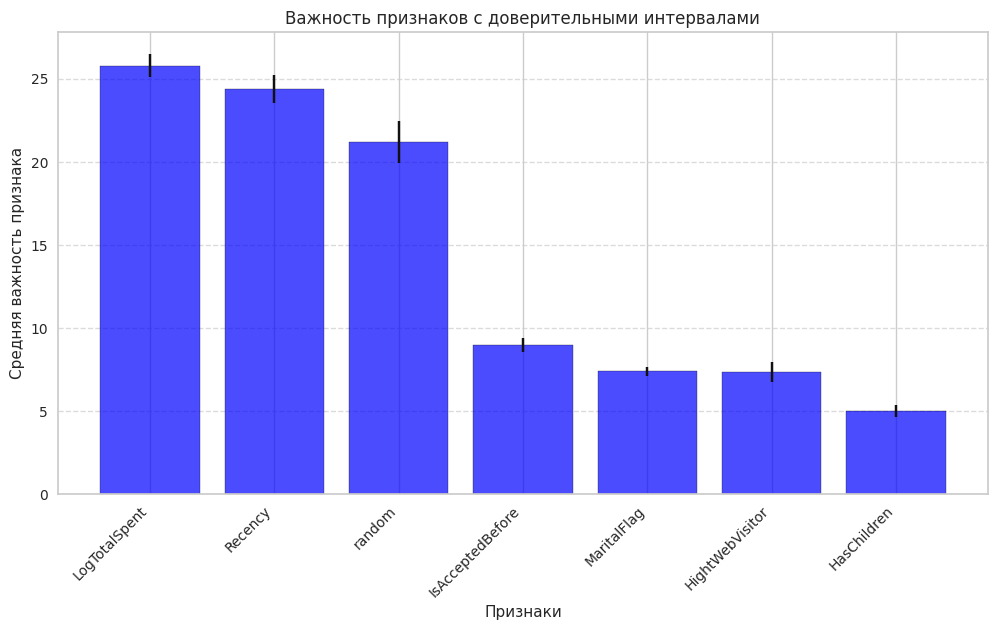

In [352]:
n_iterations = 10
features = list(X.columns) + ['random']

# Словарь для хранения значений важности признаков
feature_importance_records = {feature: [] for feature in features}

# Запускаем обучение много раз
for _ in tqdm(range(n_iterations)):
    X['random'] = np.random.random(size=len(X))
    model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
    model.fit(X, y)

    # Получаем важность признаков
    feature_importance = model.feature_importances_

    # Записываем значения в словарь
    for feature, importance in zip(X.columns, feature_importance):
        feature_importance_records[feature].append(importance)

# Создаём DataFrame с итоговыми средними и стандартными отклонениями
feature_importance_stats = pd.DataFrame({
    'feature': list(feature_importance_records.keys()),
    'mean': [np.mean(values) for values in feature_importance_records.values()],
    'std': [np.std(values) for values in feature_importance_records.values()]
}).sort_values(by='mean', ascending=False)

# display(feature_importance_stats)

plt.figure(figsize=(12, 6))
plt.bar(
    feature_importance_stats['feature'], 
    feature_importance_stats['mean'], 
    yerr=feature_importance_stats['std'], 
    capsize=5, 
    color='blue', 
    edgecolor='black', 
    alpha=0.7
)

plt.xlabel('Признаки')
plt.ylabel('Средняя важность признака')
plt.title('Важность признаков с доверительными интервалами')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение графика
plt.show()

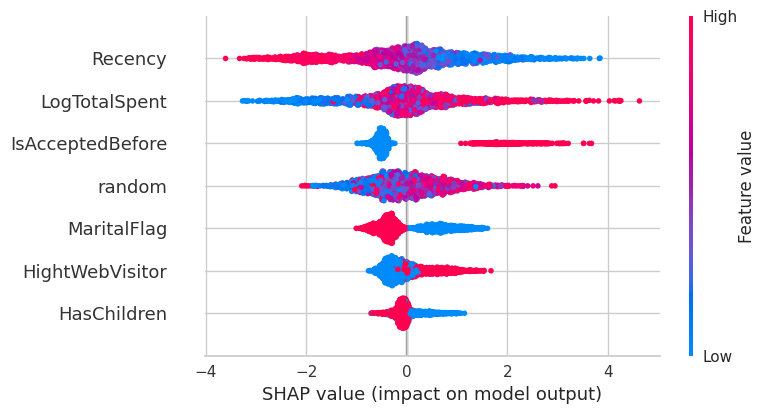

In [353]:
# Обучаем модель
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
model.fit(X, y)

# Инициализируем SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# SHAP summary plot
shap.summary_plot(shap_values, X)

In [355]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})

display(mi_df.sort_values(by='MI Score', ascending=False))

,Feature,MI Score
6,Response,0.422661052875
0,IsAcceptedBefore,0.053019290268
2,LogTotalSpent,0.046057597764
1,Recency,0.020609514361
5,HasChildren,0.011741275863
4,MaritalFlag,0.000675599286
3,HightWebVisitor,0


HightWebVisitor -  не несет никакой значимости для модели

In [358]:
from sklearn.metrics import f1_score

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.82it/s]


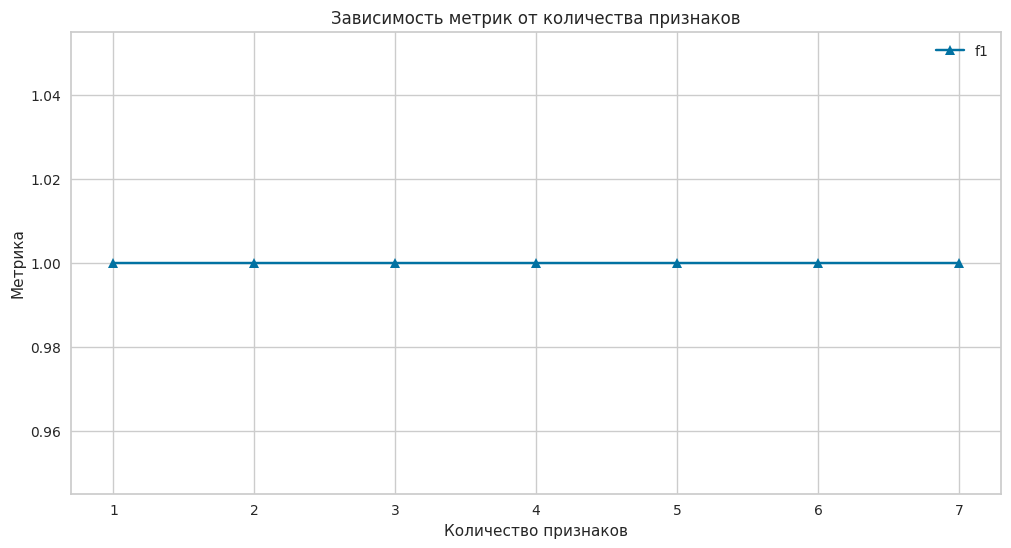

In [362]:
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
model.fit(X, y)

feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

features_sorted = feature_importance_df['Feature'].to_list()

f1_values  = []
num_features = []

# Обучаем модели с разным количеством признаков
for i in tqdm(range(1, len(features_sorted) + 1)):
    
    selected_features = features_sorted[:i]  # Берем первые i фич
    X_subset = X[selected_features]  # Оставляем только выбранные признаки
    
    # Создаем и обучаем модель
    model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
    model.fit(X_subset, y)
    
    y_pred = model.predict(X_subset)
    f1 = f1_score(y, y_pred)
    
    f1_values.append(f1)
    num_features.append(i)

# Строим график
plt.figure(figsize=(12, 6))
plt.plot(num_features, f1_values, label="f1", marker='^')
plt.xlabel("Количество признаков")
plt.ylabel("Метрика")
plt.title("Зависимость метрик от количества признаков")
plt.legend()
plt.grid(True)
plt.show()

In [363]:
print(f1_values)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [354]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# Выбираем только числовые признаки
X = data.select_dtypes(include=['float64', 'int64'])

X_const = add_constant(X)

# Считаем VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

print(vif_data)

            feature            VIF
0  IsAcceptedBefore 1.274821651081
1           Recency 1.051019511619
2     LogTotalSpent 1.313729989469
3   HightWebVisitor 1.066135869441
4       MaritalFlag 1.031493809048
5       HasChildren  1.29103692854
6          Response 1.276021170689


Мультиколинеарности нет

## Разделение данных на обучающую и тестовую выборки

In [ ]:
model_data.head(10)

In [364]:
from sklearn.model_selection import train_test_split
X = data.drop('Response', axis=1)
y = data['Response']

In [365]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Как работает этот код:
- X- признаки(фичи) всех объектов
- y- таргет(класс 0 и 1)
- test_size=0.3 - (30% данных уйдет в temp)
- random_state=42 - для воспроизводимости(чтобы разбиение было одинаковым каждый раз)
- stratify=y - это способ сбалансировать классы в тренировочной и тестовой выборке, особенно важно при несбалансированном таргете

Что я получаю?
- X_train и y_train 70% данных пойдут на обучение
- X_temp и y_temp 30% данных для дальнейшего разделения на val и test


In [366]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

Как работает этот код:
- после первого разбиения у меня  в X_temp и y_temp 30% данных
- test_size=0.5 - Это значит что из этих 30%  15% пойдут в X_test и y_test, а остальные 15% пойдут в X_val и y_val
- stratify=y_temp Гарантирует, что классы (например, 0 и 1) будут пропорционально представлены как в валидации, так и в тесте.

В итоге:
- 70% данных в X_train для обучения модели
- 15% данных в X_val для настройки гиперпараметров
- 15% данных в X_test для финальной оценки качества модели

In [367]:
print("Размер X_train:", X_train.shape)
print("Размер X_val:", X_val.shape)
print("Размер X_test:", X_test.shape)
print("Размер y_train:", y_train.shape)
print("Размер y_test:", y_test.shape)
print("Размер y_val:", y_val.shape)

Размер X_train: (1560, 6)
Размер X_val: (334, 6)
Размер X_test: (335, 6)
Размер y_train: (1560,)
Размер y_test: (335,)
Размер y_val: (334,)


In [368]:
data.head(2)

,IsAcceptedBefore,Recency,LogTotalSpent,HightWebVisitor,MaritalFlag,HasChildren,Response
0,0,58,7.388946097618,0,0,0,1
1,0,38,3.332204510175,0,0,1,0


## Масштабирование данных

In [369]:
from sklearn.preprocessing import MinMaxScaler

In [370]:
# Масштабирование данных (MinMaxScaler)
scaler = MinMaxScaler()

In [371]:
# Масштабирование тренировочных данных
X_train_scaled = scaler.fit_transform(X_train)

In [372]:
# Масштабирование валидационных и тестовых данных
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Baseline

In [381]:
from sklearn.metrics import recall_score, confusion_matrix, classification_report

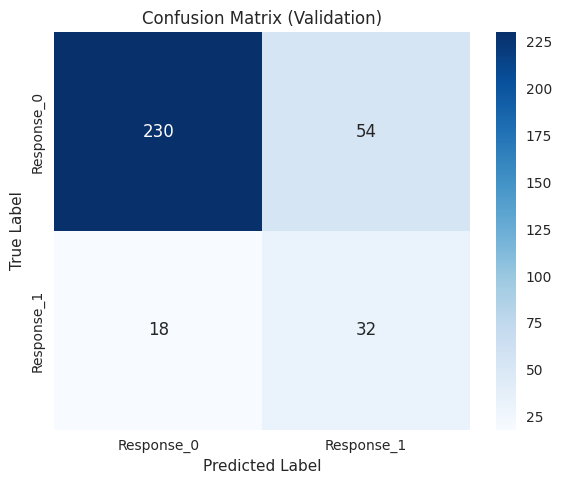

/home/alorozhkov/jup/auto_ml_venv/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Logistic_Regression_Baseline' already exists. Creating a new version of this model...
2025/05/18 19:10:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finis

🏃 View run Logistic_Regression_Baseline at: https://dagshub.com/daryafralova/MLFlow.mlflow/#/experiments/0/runs/1e3c40ff10314058b2352dc962f7aba1
🧪 View experiment at: https://dagshub.com/daryafralova/MLFlow.mlflow/#/experiments/0
Validation Recall: 0.6400


In [386]:
# Название датасета
dataset_name = "Marketing_Response"
target_names = ['Response_0', 'Response_1']

with mlflow.start_run(run_name="Logistic_Regression_Baseline"):

    # Параметры модели
    params = {
        'class_weight': 'balanced',
        'random_state': 42,
        'max_iter': 1000,
        'solver': 'lbfgs',
    }
    mlflow.log_params(params)

    # Логирование имени датасета
    mlflow.log_param("dataset_name", dataset_name)

    # Обучение модели
    model = LogisticRegression(**params)
    model.fit(X_train_scaled, y_train)

    # Предсказания на валидации
    y_val_pred = model.predict(X_val_scaled)

    # Recall
    recall = recall_score(y_val, y_val_pred)
    mlflow.log_metric("recall", recall)

    # Confusion Matrix — сохранить и отобразить
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix (Validation)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    # Показываем в ноутбуке
    plt.show()

    # Сохраняем и логируем
    plt.savefig("confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("confusion_matrix.png")

    # Classification Report
    report = classification_report(y_val, y_val_pred, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")

    # Логирование модели
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        registered_model_name="Logistic_Regression_Baseline",
        input_example=X_train_scaled[:1],
        signature=mlflow.models.infer_signature(X_train_scaled, y_train)
    )

    # Теги и описание
    mlflow.set_tags({
        "project": "Baseline classification",
        "model_type": "Logistic Regression",
        "dataset": dataset_name
    })

    # Логирование общей информации
    mlflow.log_param("num_features", X_train.shape[1])
    mlflow.log_param("num_classes", len(target_names))

print(f"Validation Recall: {recall:.4f}")

In [387]:
# Название датасета
dataset_name = "Marketing_Response"
target_names = ['Response_0', 'Response_1']

mlflow.set_experiment("LogisticRegression_Baseline_Threshold_0.3")
# Предсказания вероятностей
y_val_probs = model.predict_proba(X_val_scaled)[:, 1]

# Заданный порог
threshold = 0.3
y_val_pred_thresh = (y_val_probs >= threshold).astype(int)

# Метрика recall при изменённом пороге
recall_thresh = recall_score(y_val, y_val_pred_thresh)
print(f"Recall при пороге = {threshold}: {recall_thresh:.4f}")

# Логируем в MLflow
mlflow.log_param("threshold", threshold)
mlflow.log_metric("recall@threshold", recall_thresh)

2025/05/18 19:18:19 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegression_Baseline_Threshold_0.3' does not exist. Creating a new experiment.


Recall при пороге = 0.3: 0.8800


RestException: INVALID_PARAMETER_VALUE: Response: {'error_code': 'INVALID_PARAMETER_VALUE'}

## AutoML - Pycaret

Использую  X_train_scaled и y_train для обучения в PyCaret
После выбора лучшей модели проверю ее на X_val_scaled и X_test_scaled

In [ ]:
X_train_scaled

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [ ]:
# Объедию с целевой переменной
train_df = pd.concat([X_train_scaled_df, y_train.reset_index(drop=True).rename("Response")], axis=1)

In [ ]:
train_df

In [ ]:
class_balance = train_df['Response'].value_counts()

print(class_balance)

In [ ]:
clf_setup = setup(
    data=train_df,
    target='Response',
    fold=10,        
    session_id=42,
    train_size=0.9,          
    normalize=False,          # Уже масштабировано
    fix_imbalance=True,       # Включаем авто-балансировку из-за дисбаланса
)

In [ ]:
best_model_second = compare_models(sort='Recall')

### Анализ на валидационной выборке

In [ ]:
# Преобразуем масштабированные признаки в DataFrame
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_train.columns)

In [ ]:
# Объединяем с таргетом
val_df = pd.concat([X_val_scaled_df, y_val.reset_index(drop=True).rename("Response")], axis=1)

In [ ]:
final_model_2 = finalize_model(best_model_second)
predictions_2 = predict_model(final_model_2, data=val_df)  # X_val_scaled + y_val

In [ ]:
plot_model(final_model_2, plot='feature')

### Cлучайная фича + feature importance

## Трекинг экспериментов

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:
# Логирование эксперимента в MLflow
with mlflow.start_run():
    mlflow.log_param("Model", "SVM - Linear Kernel")
    
    # Обучаем модель SVM
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train_scaled, y_train)

    # Прогнозы на валидации
    y_pred_svm = svm_model.predict(X_val_scaled)

    # Логируем метрики
    recall = recall_score(y_val, y_pred_svm)
    precision = precision_score(y_val, y_pred_svm)
    f1 = f1_score(y_val, y_pred_svm)

    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("F1", f1)

    # Логируем модель
    mlflow.sklearn.log_model(svm_model, "model")

    print(f"SVM Recall: {recall}")
    print(f"SVM Precision: {precision}")
    print(f"SVM F1: {f1}")

In [ ]:
# Предполагаем, что ты уже обучил модель и у тебя есть предсказания
y_pred_svm_proba = svm_model.decision_function(X_val_scaled)  # или любая другая вероятность, если есть

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_val, y_pred_svm_proba)
roc_auc = auc(fpr, tpr)

# Логируем ROC-кривую
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Сохраняем изображение
plt.savefig("roc_curve.png")

# Логируем изображение в MLflow
with mlflow.start_run():
    mlflow.log_artifact("roc_curve.png")

In [ ]:
# Логирование эксперимента в MLflow
with mlflow.start_run():
    mlflow.log_param("Model", "Logistic Regression")
    
    # Обучаем модель Logistic Regression
    logreg_model = LogisticRegression(random_state=42)
    logreg_model.fit(X_train_scaled, y_train)

    # Прогнозы на валидации
    y_pred_logreg = logreg_model.predict(X_val_scaled)

    # Логируем метрики
    recall = recall_score(y_val, y_pred_logreg)
    precision = precision_score(y_val, y_pred_logreg)
    f1 = f1_score(y_val, y_pred_logreg)

    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("F1", f1)

    # Логируем модель
    mlflow.sklearn.log_model(logreg_model, "model")

    print(f"Logistic Regression Recall: {recall}")
    print(f"Logistic Regression Precision: {precision}")
    print(f"Logistic Regression F1: {f1}")